In [88]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import init_lattice as lat
import MH_algorithm as MH
import Wolff_algorithm as W
import time
import autocorrelation_functions as acf
importlib.reload(MH)
importlib.reload(W)
importlib.reload(lat)
importlib.reload(acf)

<module 'autocorrelation_functions' from 'c:\\Users\\jackb\\github-classroom\\Part-II-Computational-Physics\\cluster-algorithms-for-monte-carlo-jbd29\\autocorrelation_functions.py'>

# Monte Carlo and Wolff Cluster algorithms for the 2D Ising Model

## Abstract

The 2-dimensional Ising model for ferromagnets is a common and well researched topic in statistical mechanics both computationally and analytically. Many different algorithms with differing complexities and strengths have been devised to simulate the behaviour of this model. In this project, the behaviour and complexity of the Metropolis-Hastings and Wolff Cluster algorithms applied to this context was investigated. This report focuses particularly on the simulated behaviour at and around the critical temperature $T_c$ of the continuous phase transition, where these algorithms differ. An attempt to determine the utility of these algorithms in the limit of large lattices was made by measurement of the dynamic component $z$.

The Wolff algorithm and Metropolis-Hastings algorithm were studied to assess their efficiency and performance in simulating the 2-dimensional Ising model. An implementation of each was written in python and their behaviour around the continuous phase transition investigated. Both showed good agreement to known analytical solutions. The critical temperatures measured was $2.09 \pm 0.22$ for both the Wolff and Metropolis-Hasstings algorithms. This is within error of previously published values. The autocorrelation time of both algorithms was measured against temperature and lattice width. Both algorithms showed a noteable peak in autocorrelation time in the critical region, although the autocorrelation of the Wolff algorithm was smaller than or of comparable size to the Metropolis-Hastings autocorrelation. Attempts to measure the dynamic exponent for both algorithms were far from literature values and neither regression fit was significant. Dependence of time to execute a single iteration on coupling strength and lattice size were also investigated. Wolff displayed $\mathcal{O}(N)$ dependence on number of spins and a complex dependence on the temperature. Metropolis-Hastings execution time displayed no dependence on either condition, and a single iteration was consistently faster than Wolff.

## 1 - Introduction

In this report, the Metropolis-Hastings and Wolff algorithms are implmemented and their performance and results are investigated. Of particular focus is the issue of *critical slowing down*. This is a phenomena that occurs near to the continuous phase transition, where both algorithm take significantly larger numbers of iterations to produce independent samples of the measurement at hand. The performance of these algorithms, in terms of dynamic exponent and agreement to the analytic Onsager solution is explored below.

## 2 - Theory

### 2.1 - Background Theory

The Ising model considers individual spins, $\sigma_i$, arranged in space. For the purposes of this report, spins will be placed upon an $L\times L$ square lattice. This model assumes that these individual spins may be directed only up or down, i.e. $\sigma_i = \pm 1$, and that each spin interacts with only its nearest neighbours on the lattice. The total energy of the system is then:

$ E = -J \sum_i \sum_j \sigma_i \sigma_j - \mu H \sum_i \sigma_i $ (1) [1]

where for each spin $i$ its nearest neighbours, $j$, are summed over. Additionally, $J$ is the ferromagnetic coupling, $\mu$ is the spin's magnetic moment and $H$ is the external magnetic field. In this report, we will be considering the zero external magnetic field regime.

Typical state observables of interest for this system are the absolute magnetism per spin $\vert M \vert$, And the internal energy (equation (1)).

$ \vert M \vert = \vert \frac{1}{N} \sum_{i = 1}^N \sigma_i \vert $ (2)

For ensemble systems, The expectation value of a state observable $f$ is found using:

$ \mathbb{E}(f) = \sum_{\sigma states} f(\sigma)p(\sigma)$ (3)

with $p(\sigma)$ being the probabilty density for a specific $\sigma$ state. From statistical mechanics, recall that for such a system,

$ p(\sigma) = \frac{e^{- \beta E}}{Z} $ (4)

Where $Z = \sum_{states} e^{-\beta E_{state}}$ is the partition function, and $\beta = \frac{1}{k_b T}$. For convenience, $\beta = 1$ throughout this report. From these measurements, two *derived observables* of the system which are of interest can also be found. Firstly, the magnetic susceptibility, $\chi$:

$ \chi \propto \beta(\langle M^2 \rangle - \langle M \rangle ^2) = \beta Var(M)$ (4)

and the heat capacity, $C$:

$ C \propto \beta^2 (\langle E^2 \rangle - \langle E \rangle ^2) = \beta ^2 Var(E)$ (5)

These are known as derived variables as they require several measurements of $M$ or $E$ respectively to be found.

For a general Ising system, whilst $Z$ is constant, it is not feasibly calculable. To illustrate this consider an $N \times N$ lattice of spins. To compute $Z$, we must (at worst) sum up $2^{N \times N}$ terms for each possible lattice configuration; this sum quickly becomes astronomic in scale. Hence, we must approach this problem in a manner that depends only on relative likelihood, not absolute probability as this allows $Z$ to be disregarded.

In some limiting cases, the behaviour of this system is analytically solvable, for example the Onsager solution for 2 dimensions with no external field, this is typically tedious, or infeasibly complex. This is the motivation for studying this system with computational methods. However, comparison of computational methods to the establsihed Onsager solution is a convenient sanity check for the accuracy and precision.

### 2.2 - The Onsager Solution

In 1944, Onsager found an analytical expression for the free energy and magnetism of the 2D square lattice Ising model in the limit of $L \rightarrow \infty$ and with no eternal magnetic field. Below is the solution for the magnetisation In the case relevant to this report, with isotropic couping:

$\mathbb{E}(M) = (1 - (sinh(2 \beta J)^{-4}))^{\frac{1}{8}} $ for $ T \le T_c $

$\mathbb{E}(M) = 0$ for $ T > T_c $ (6) [2]

The non zero solution clearly is only defined if $sinh(2 \beta J) \ge 1$. This defines our *critical temperature*, $T_c = \frac{2 J}{ln(1 + \sqrt{2})} \approx 2.27J$ . There is a continuous phase transition at $T = T_c$ at which the spins rapidly transition from ordered to disordered, leading to the order parameter, $\vert M \vert$, changing abruptly. Figure 1 plots this solution.

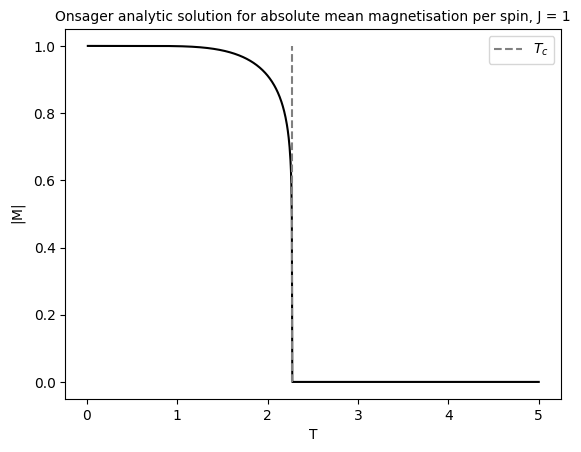

In [6]:
# Plot Onsager solution, J = 1:
J = 1
Ts_analytic = np.linspace(0.01,5,1000)
T_c = 2*J/np.log(1 + np.sqrt(2)) # Critical temperature

# Construct absolute magnetism:
M_analytic = []

for T in Ts_analytic:
    if T < T_c:
        M_analytic.append(np.power(1 - np.power(np.sinh(2*J/T),-4),1/8))
    else:
        M_analytic.append(0)

# Plot:
plt.plot(Ts_analytic, M_analytic, color = 'black')
plt.plot(np.full((5,1),T_c), np.linspace(0,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.xlabel('T')
plt.ylabel(r'$\vert$M$\vert$')
plt.title('Onsager analytic solution for absolute mean magnetisation per spin, J = ' + str(J), fontsize = 10)
plt.legend()
plt.show()

*Fig. 1 - mean magnetisation per spin against temperature for the Onsager solution.*

As mentioned, the Onsager solution applies only to an infinite lattice. This cannot be implemented into a computational model, therefore finite lattices with periodic boundaries are to be considered in this report. It is expected that for finite lattices that there will be a 'smoothing out' of the Onsager solution. An analytic example of this must be calculated by exhaustion to find all possible states and the associated Boltzmann factor and partition function. 

The exhaustion method to obtain the spontaneous magnetisation per spin was performed for a $2 \times 2$ lattice without perioidic boundary conditions. Figure 2 illustrates all possible permutations of this lattice
Consider all the permutations of the $2 \times 2$ lattice, along with the associated $E$ and $\vert M \vert$:


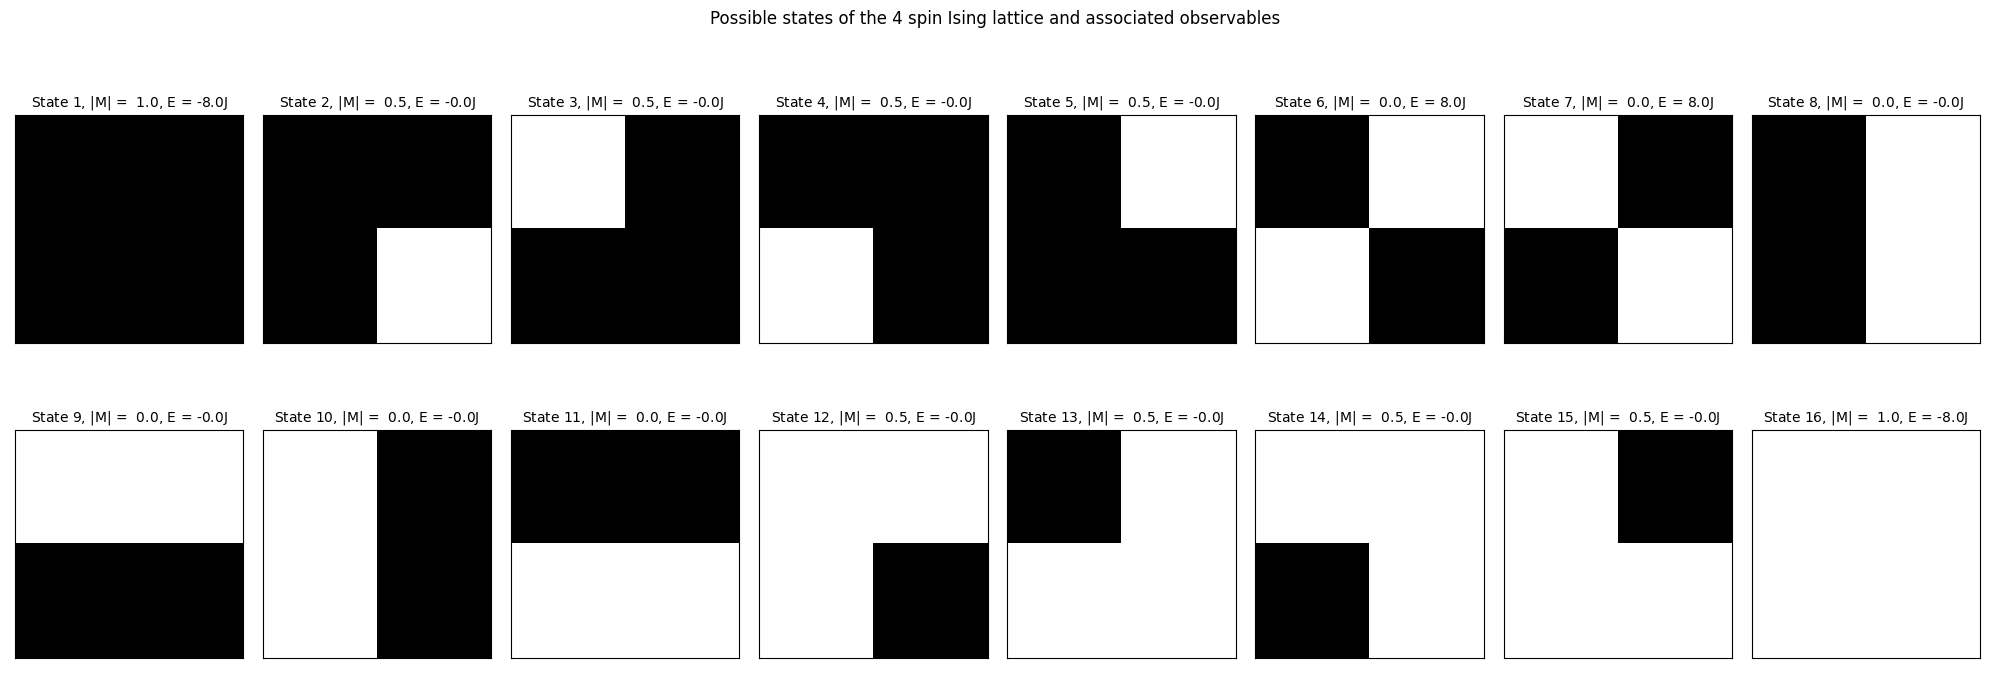

In [7]:
import itertools

#write a lattice for each number of -1 entries:
lattices = [[[1.,1.], [1.,1.]], [[-1.,1.], [1.,1.]], [[-1.,-1.], [1.,1.]], [[-1.,-1.], [-1.,1.]], [[-1.,-1.], [-1.,-1.]]]

# Write a function to split into individual elements to use itertools on, and then generate all permutations
def permutations(lattice):
    #split into  list of elements
    temp = []
    for i in lattice:
        for j in i:
            temp.append(j)
    
    # Use itertools to generate permutations and then use set to remove duplicates
    permutations = list(set(itertools.permutations(temp,np.size(lattice))))
    #print(len(permutations))
    # Reshape into lattices
    for i in range(len(permutations)):
        permutations[i] = np.reshape(np.array(permutations[i]), (len(lattice),len(lattice)))
    
    return permutations

fig, ax = plt.subplots(2,8, figsize = (20,7.5))

i = 0
for lattice in lattices:
    perms = permutations(lattice)
    for state in perms:
        #Find energy without periodic BCs
        E = -(state[0][0]*(state[1][0] + state[0][1]) + state[1][0]*(state[0][0] + state[1][1]) + state[0][1]*(state[0][0] + state[1][1]) + state[1][1]*(state[1][0] + state[0][1]))
        lat.show_lattice(state,ax[0 if i < 8 else 1][i%8],'State ' + str(i + 1) + r', $\vert$M$\vert$ =  ' + str(np.abs(lat.compute_magnetisation(state))) + ', E = ' + str(E) + 'J')
        i += 1

fig.suptitle('Possible states of the 4 spin Ising lattice and associated observables')
plt.tight_layout()

*Fig. 2 - possible lattice states and there associated* $\vert M \vert$ *and* $E$. 

It is clear that there are three energy states; $E = -8J$ with degeneracy 2, $E = 8J$ with degeneracy 2 and $E = 0$ with degeneracy 12. Therefore, $Z = 2 e^{8\beta J} + 2 e^{-8 \beta J} + 12 = 4cosh(8 \beta J) + 12$. Using equation (3) we obtain: 

$\mathbb{E}(\vert M \vert) = \frac{2 e^{8 \beta J} + 4}{4cosh(8 \beta J) + 12}$

$\mathbb{E}(E) = - \frac{8sinh(8 \beta J)}{4cosh(8 \beta J) + 12}$ (7)

Figure three plots this solution against temperature along with the Onsager solution.

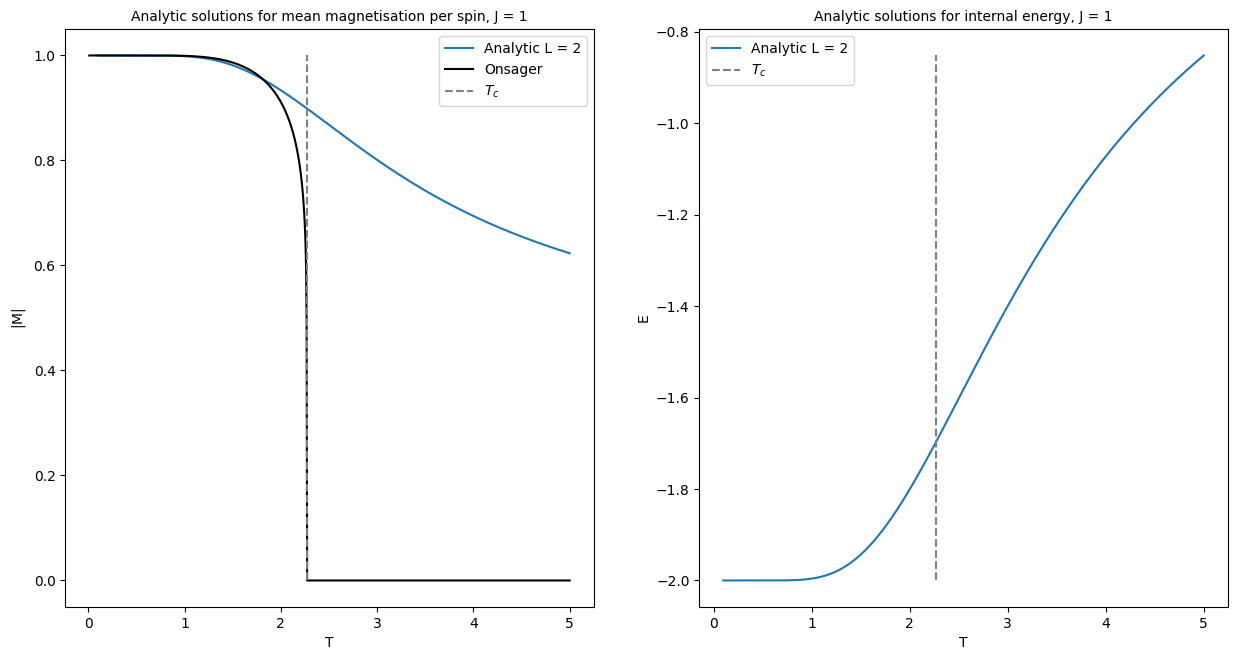

In [9]:
# Initialise
Ts_2x2 = np.linspace(0.1,5,1000)
Ms_2x2 = []
Es_2x2 = []

# Generate analytic data
for T in Ts_2x2:
    Ms_2x2.append((2*np.exp(8*T**-1)+4)/(4*np.cosh(8*T**-1)+12))
    Es_2x2.append(-8*np.sinh(8*T**-1)/(4*np.cosh(8*T**-1)+12))

# Plot
fig, ax = plt.subplots(1,2, figsize = (15,7.5))
ax[0].plot(Ts_2x2, Ms_2x2, label = 'Analytic L = 2')
ax[0].plot(Ts_analytic, M_analytic, color = 'black', label = 'Onsager')
ax[0].plot(np.full((5,1),T_c), np.linspace(0,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
ax[0].set_xlabel('T')
ax[0].set_ylabel(r'$\vert$M$\vert$')
ax[0].set_title('Analytic solutions for mean magnetisation per spin, J = ' + str(J), fontsize = 10)
ax[0].legend()
ax[1].plot(Ts_2x2, Es_2x2, label = 'Analytic L = 2')
ax[1].plot(np.full((5,1),T_c), np.linspace(np.min(Es_2x2),np.max(Es_2x2),5), linestyle = '--', color = 'gray', label = r'$T_c$')
ax[1].set_xlabel('T')
ax[1].set_ylabel('E')
ax[1].set_title('Analytic solutions for internal energy, J = ' + str(J), fontsize = 10)
ax[1].legend()
plt.show()

*Fig. 3 - The Onsager solution and analytic mean magnetisation per spin and internal energy solutions against temperature*

It is infeasible to repeat this process for lattices of any useful size due to the $2^{N \times N}$ possible states. For example $N = 5$ gives $33554432$ possible states, making $Z$ infeasibly hard to find. Due to this, an alternative approach to the simulation of larger lattices is needed. This is the aim of the Markov Chain Monte Carlo algorithms, otulined below.

### 2.3 - Markov Chain Monte Carlo

The two algorithms investigated are variations of a Markov Chain Monte Carlo (MCMC) method, that approach and evolve the desired physical state. Direct sampling Monte Carlo, while simpler, would require individually producing each state $X_i$. This is infeasibly slow. Instead, we use the MCMC methods, which produce a state $X_{i + 1}$ from an alteration of the $X_i$ state. One of the downsides of the MCMC methods is that this means consecutive states are not independent. This is quantified by the sample autocorrelation, discussed in more detail in section 4.

The MCMC starts with some initial state, $x_0$, and a state $x_{i+1}$ is produced from a state $x_i$ with a transition probability $p(x_{i + 1} \vert x_{i})$. Therefore the the chance of a particular sequence of states from $x_0$ to $x_n$ is:

$p_{path}(x_0 \rightarrow x_n) = p(x_0)\prod_{i = 0}^n p(x_{i + 1} \vert x_{i})$ (8)

*(This assumes that our markov chain is time homogenous, i.e. the chance of the transition $i \rightarrow j$ is irrelevant of the step in which the transition occurs)*

Suppose now we wish to simply find the chance of arriving at the state $x_n$ in $n$ steps, $p^{(n)}(x)$, regardless of path. Naively, this would involve summing over every singly possible path to every single possible final value to get the full distribution.

This can also be represented as taking a vector $\overrightarrow{p}^{(1)}$ whose $j^{th}$ element is $p^{(1)}(j)$ and acting on it $n-1$ times with a matrix $\textbf{P}$, with elements $\textbf{P}_{ij} = p(i \vert j)$:

$ \overrightarrow{p^{(n)}} = \textbf{P}^{n-1} \overrightarrow{p^{(1)}} $ (9)

For physical systems that reach equilibrium, we expect that, as $ n \rightarrow \infty$, our state vector will approach an unchanging distribution. This is called the *stationary distribution* and is commonly represented with $\pi$. As this stationary distribution does not change, trivially:

$ \pi\textbf{P} = \pi$ (10)

To implement MCMC algorithms, one must look for a method to find the transition matrix, $\textbf{P}$, from the intended stationary distribution. However, for complicated systems such as the Ising model studied here, $\pi$ cannot be analytically calculated and supplied. Therefore a different approach is required.

Firstly, note that our energy equation above is time-reversal symmetric as is the system, hence the probability of $i \rightarrow j$ is equal to the probability $j \rightarrow i$ for a step in the markov chain.

From this follows:

$ \pi_j\textbf{P}_{jk} = \pi_k = \textbf{P}_{jk}\pi_k $ (11)

using the eigenvector property of $\pi$ additionally. This constraint is known as *detailed balance*, and enables the use of simpler distributions to converge on the static distribution.

To approach this, each element of $\textbf{P}$ is split into a proposal probability distribution, $p_prop(j \vert k)$, that gives the chance of attempting to reach state $k$ from $j$, and an acceptance distribution, $p_{acc}(j \rightarrow k)$, that gives the chance of the change of state being accepted:

$ p( j \vert k) = p_{acc}(j \rightarrow k) p_{prop}(j \vert k) $ (12)

With the detailed balance condition, this results in the condition:

$\frac{p_{acc}(j \rightarrow k)}{p_{acc}(k \rightarrow j)} = \frac{\pi_k}{\pi_j} \frac{p_{prop}(j \vert k)}{p_{prop}(k \vert j)} $ (13)

A $p_{acc}$ is sought that satisfies this constraint.

### 2.4 - The Metropolis-Hastings algorithm

The Metropolis-Hasting (MH) algorithm follows the above logic, and the choice of $p_{acc}$ is:

$p_{acc}(j \rightarrow k) = min(1,\frac{\pi_k}{\pi_j} \frac{p_{prop}(j \vert k)}{p_{prop}(k \vert j)})$ (14)

The general MH algorithm proceeds as follows from a starting state $j$:

1. From an initial state $j$, pick a new state $k$ in line with the $p_{prop}$ distribution.
2. Accept the transition to $k$ with probability $p_{acc}(j \rightarrow k)$, and move to state $k$, or reject the move (with probability $ 1 - p_{acc}(j \rightarrow k )$) and remain in state $j$.
3. Return to 1.

This algorithm does not have a defined end point, so the end point is determined in this report by a predetermined number of iterations. This can be defined more rigorously later on, through utilisation of the autocorrelation time, $\tau_f$. Independent samples are generally considered to have occured every $\sim 2 \tau_f$, hence the number of total iterations can be varied, but should be several $\tau_f$.[3]

To apply this to the Ising model, states $j, k, etc.$ are taken to be unique arrangements of spins in the lattice. This means for a lattice containing $N$ spins, there are have $2^N$ possible states. New states $k$ are generated by choosing a random spin in $j$ and flipping it. The spin to flip is chosen from a uniform random distribution, hence $p_{prop}(k \vert j) = \frac{1}{N}$. The sought stationary distributions is equation (4), combining this with (11):

$p_{acc}(j \rightarrow k) = min(1, \frac{e^{-\beta E_k}}{e^{- \beta E_j}}) = min(1, e^{-\beta \Delta E})$ (15)

Notice that the partition function, $Z$, is not a dependent of $p_{acc}$, as it is cancelled in the ratio $\frac{\pi_k}{\pi_j}$.

From equation (1),

$\Delta E = 2 J \sigma_i \sum_j \sigma_j + 2 \mu H \sigma_i  $ (16) [2]

For the flip of a spin at a location $i$, with near neighbours $j$

This algorithm is easy to implement, but has a few shortcomings. Firstly, about the critical temperature, $T_c$, where the lattice undergoes a sharp change in behaviour, the MH algorithm displays an inherent issue of critical slowing down - the lattice has global behaviour which cannot be captured in flipping a single spin, and hence many iterations are required to reach a reliable stationary distribution.

MH also has some intrinisic properties. Firstly, it is a completely general MCMC technique that can be applied to most statistical physics problems, for example it is also applicable to the hard disk crystal model [4]. Additionally, MH can quite easily be parallelised to allow for faster computation. The implementation of MH used in this report is included in the GitHub repository as *MH_algorithm.py*

### 2.5 - The Wolff Cluster algorithm

The Wolff cluster algorithm is a separate algorithm used for the Ising model. It seeks to reach the stationary distribution quicker, and mitigate the issue of critical slowing down by forming clusters of like spins within the lattice and attempting to flip them all at once. This allows it to reach likely states that are significantly different from the current state in many fewer iterations by flipping a large number of spins together in each iteration. This algorithm as applied to the Ising model proceeds as follows:

1. A random site in the lattice $i$ with spin $\sigma_i$ is picked and added to the cluster.
2. Each neighbour of $i$ that also has spin $\sigma_i$, is added to the cluster with probability $1- e^{-2 \beta J}$.
3. Repeat step 2 for each neighbour added to the cluster until no more spins are added to the cluster.
4. Now that the cluster is defined flip each spin in the cluster and return to step 1. [5]

This is a rejection free algorithm, which means that in each iteration at least one spin is flipped and the state is changed. Therefore, this algorithm will display (usually small) fluctuations about equilibrium, whereas the MH algorithm will not necessarily.

The Wolff algorithm as outlined above is specific to the Ising model and cannot be applied to other problems that require an MCMC approach. This is a major disadvantage in comparison to the MH algorithm. It can be parrallelised like the MH algorithm [6]. The implementation of Wolff used in this report is included in the GitHub repository as *Wolff_algorithm.py*.

### 2.6 - Autocorrelation and quantification of critical slowing down

In order to investigate the feasability and scaling of these algorithms, an estimate of the number of iterations needed between independent samples of the lattice are needed. It is generally considered that an independent sample can be taken every $\sim 2\tau_f$ iterations, where $\tau_f$ is the autocorrelation time, and it can be estimated as follows:

To estimate the autocorrelation time, the *sample autocorrelation*, $\bar\rho(t)$ is required:

$\bar\rho(t) = \frac{\bar\gamma(t)}{\bar\gamma(0)}$ (17)

Where $\bar\gamma(t)$ is the *sample autocovariance*, defined below:

$\bar\gamma(t) = \frac{1}{n-t}\sum_{i=1}^{n-t}(f(X_i)-\bar f(X))(f(X_{i+t})-\bar f(X))$ (18)

This sample autocorrelation is a convenient measure of the degree of correlation of the observable $f$ on state $X_t$ at time $t$ with other states in the chain. To determine autocorrelation time, it is assumed that $\bar\rho(t)$ decays exponentially, with the characteristic decay scale of the autocorrelation time, $\tau_f$:

$\bar\rho(t) \approx e^{{t}/{\tau_f}}$ (19) [4]

Under this assumption, the autocorrelation time is estimated by the time of the first value of $\bar\rho(t)$ such that $\bar\rho(t) \le \frac{1}{e}$. It is also important to note that the autocorrelation time will be different for different variables.

If $n$ states have been generated in a simulation, there are roughly $n_f = \frac{n}{2\tau_f}$ independent samples generated for the observable $f(X)$. This shows that for a larger autocorrelation time, a smaller number of independent samples can be collected, and more iterations are needed. Therefore,the interations required to take a representative average of an observable becomes much larger. This is *slowing down* of the algorithm.

The Ising model has critical exponents, similar to many thermodynamic systems that display a phase transition. As $T \rightarrow T_c$, these can be used to describe the behaviour of observables using simple power laws.

$\xi \sim \vert T - T_c \vert ^{-\nu}$

$\chi \sim \vert T - T_c \vert ^{-\gamma}$

$C \sim \vert T - T_c \vert ^{-\alpha}$

$\tau_f \sim \vert T - T_c \vert ^{-\nu z}$ (20)[5]

where $\xi$ is the correlation length of the lattice, and $\nu$, $\alpha$ and $\gamma$ are the critical exponents of the Ising model. In two dimensions, $\nu = 1$, $\alpha = 0$, $\gamma = \frac{7}{4}$ [7]. Note that critical exponents are a universal property of the model and do not change between algorithms. $z$ is the *dynamic exponent* and does vary between algorithms. Clearly, near the critical temperature the autocorrelation time for our algorithms is expected to be very large, and collecting independent samples quickly becomes infeasible. This is *critical slowing down* and presents a significant challenge to the computational investigation of the system with these methods.

For an infinite lattice near $T_c$, $\xi$ will diverge towwards infinity, as the lattice displays fluctuations on all scales. However, for finite lattices this is not possible. Therefore, near $T_c$, $\xi \sim L$ where $L$ is the lattice width. Using this, in the critical regime:

$\tau_f \sim L ^{z}$

$ln(\tau_f) \sim zln(L)$ (21)

This describes the finite scaling of the algorithm. Any algorithm with a positive dynamic exponent will display the issue of critical slowing down. The magnitude of $z$ determines the severity in terms of iterations. A method with a smaller dynamic exponent will take many fewer iterations per independent sample, and hence will be a more feasible method for large lattices, even if the CPU time for a single iteration is much longer.

### 2.7 - Collecting independent measurements

Each state in the Markov Chain is generated from the previous state. Therefore, two states $X_i$ and $X_{i + 1}$ cannot be considered to be independent measurements of the system. To obtain statistically independent measurements, the states $X_i$ and $X_j$ must be significantly decorrelated. This is by convention considered to be satisifed when $j \ge i + 2 \tau_f$.

The error in these observables must also be treated with care. The expectation value of an observable $f(X)$ can be determined through the sample mean, and the error in this measurmeent through the error of the mean. For $n$ samples taken in the thermalised region, therefore:

$\mathbb{E}(f(X)) = \frac{1}{n} \sum_i^n f(X_i)$ (22)

A naive estimate of the error, assuming each data point is fully independent is given by:

$\sigma_{f(X)}^2 = \frac{1}{n - 1} (\langle f(X)^2 \rangle - \langle f(X) \rangle)$ (23)

To account for the fact that each data point is not independent, a different measure of the error is required:

$\sigma_{f(X)}^2 = \frac{1 + 2 \tau_f}{n - 1} (\langle f(X)^2 \rangle - \langle f(X) \rangle) \approx \frac{1}{n_f - 1}  (\langle f(X)^2 \rangle - \langle f(X) \rangle)$ (24)

With $n_f$ as defined above and assuming that $\tau_f \gg 1$ [3].

To utilise a simulated series of $n$ meassurements of an observable after thermalisation and produce a utilisable mean and error, a blocking method is used. A series of $n$ data points is divided into bins of approximately $ 1 / 2 \tau_f $ elements. As each data set starts at state $X_{ m \times 2 \tau_f }$ for integral $m$, each set may be treated as an entire sample, with mean and error given by equations (21) and (23). This is further useful for the calculation of derived variables such as **VAR**, as these necessarily require a series of measurements to calculate. Each batch can be treated as a series, and an expectation and error can be found using the mean and the naive mean error. 
 


## 3 - Investigation

### 3.1 - Qualitative investigation of the lattice evolution

As a first test of the MH and Wolff algorithms, A $25 \times 25$ lattice is evolved and displayed to determine visually if the algorithms perform as expected.

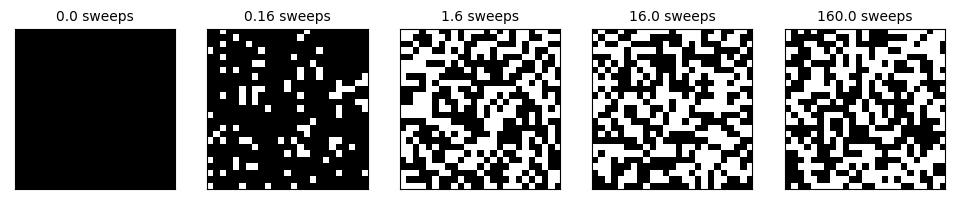

Time to execute = 2.258 seconds.


In [10]:
# Initialise lattice
lattice = lat.make_lattice(25,1)
plot_times = [0,100,1000,10000,100000]
# Time run length:
start_time = time.time()
# Evolve
MH.evolve_and_show(lattice, 2, 0,0, plot_times)
end_time = time.time()
print('Time to execute = ' + str(np.round(end_time-start_time,3)) + ' seconds.')
plt.show()

*Fig. 4 - Evolution of a $25 \times 25$ lattice with the Metropolis-Hastings algorithm, $J = 0$, $T = 0.5$*

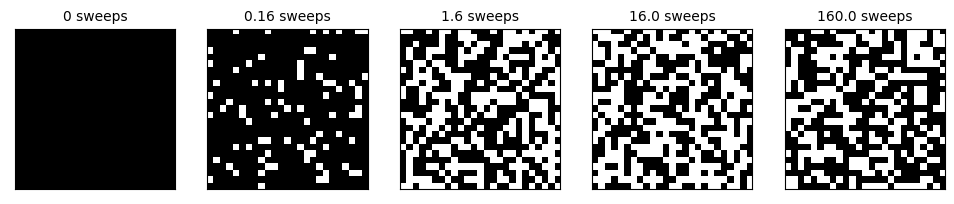

Time to execute = 9.990496158599854 seconds.


In [11]:
# Re-initialise lattice
lattice = lat.make_lattice(25,1)
# Time run length:
start_time = time.time()
# Evolve
W.Wolff_evolve_and_show(lattice, 2, 0, plot_times)
end_time = time.time()
print('Time to execute = ' + str(end_time - start_time) + ' seconds.')


*Fig. 5- Evolution of a $25 \times 25$ lattice with the Wolff algorithm, $J = 0$, $T = 0.5$*

Both algorithms lead to the progression of the lattice from its initial state to a random spin assortment. This is to be expected at non-zero temperatures in the presence of no coupling, as with $J = H = 0$, the Ising energy is 0, so any state is equally likely. The Wolff algorithm takes $\sim 10 $ times longer. This will be explored further later in the report.

### 3.2 - Thermalisation

Before any measurements of observables can be taken, the system must be allowed to reach equilibrium, where the transient behaviour from the intiial condition to equilibrium has diminished, and the observable is thermally fluctuating about a fixed value. The absolute magnetism per spin versus sweeps is plotted below for a $25 \times 25$ lattice, from a hot start.

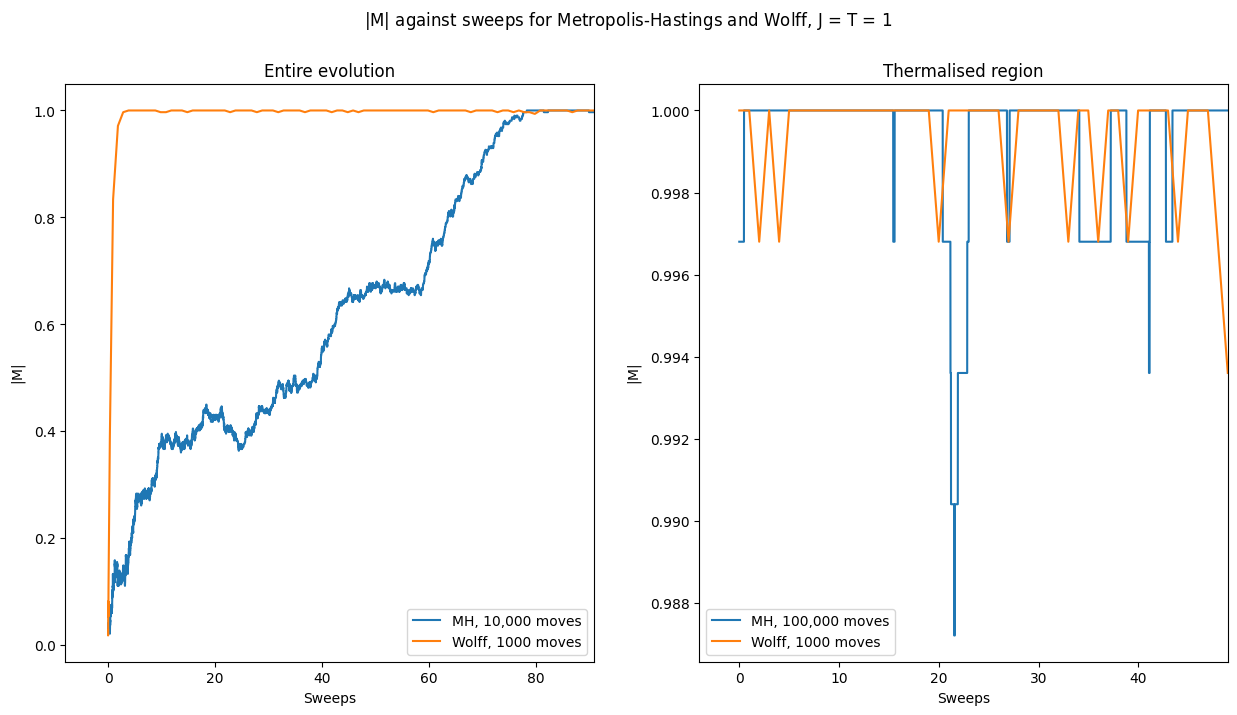

In [12]:

# Load Data:
MH_sweeps = np.load('MH_thermalisation_sweeps.npy')
MH_Ms = np.load('MH_thermalisation_Ms.npy')
MH_thermal_Ms = np.load('MH_thermalised_Ms.npy')
MH_thermal_sweeps = np.load('MH_thermalised_sweeps.npy')
Wolff_Ms = np.load('Wolff_thermalisation_Ms.npy')
Wolff_sweeps = np.load('Wolff_thermalisation_sweeps.npy')
Wolff_thermal_Ms = np.load('Wolff_thermalised_Ms.npy')
Wolff_thermal_sweeps = np.load('Wolff_thermalised_sweeps.npy')

# Plot data
fig, ax  = plt.subplots(1,2, figsize = (15,7.5))
ax[0].plot(MH_sweeps, MH_Ms, label = 'MH, 10,000 moves')
ax[0].plot(Wolff_sweeps, Wolff_Ms, label = 'Wolff, 1000 moves')
ax[0].set_xlim(right = min(MH_sweeps[-1],Wolff_sweeps[-1]))
ax[0].legend()
ax[1].plot(MH_thermal_sweeps, MH_thermal_Ms, label = 'MH, 100,000 moves')
ax[1].plot(Wolff_thermal_sweeps, Wolff_thermal_Ms, label = 'Wolff, 1000 moves')
ax[1].set_xlabel('Sweeps')
ax[0].set_xlabel('Sweeps')
ax[1].set_xlim(right = min(MH_thermal_sweeps[-1],Wolff_thermal_sweeps[-1]))
ax[1].set_ylabel(r'$\vert$M$\vert$')
ax[0].set_ylabel(r'$\vert$M$\vert$')
ax[0].set_title('Entire evolution')
ax[1].set_title('Thermalised region')
ax[1].legend()
fig.suptitle(r'$\vert$M$\vert$ against sweeps for Metropolis-Hastings and Wolff, J = T = 1')
plt.show()

*Fig. 6 showing the magnetisation evolution from a hot start for Metropolis-Hastings and Wolff.*

Both algorithms display similar equilibrium behaviour, settling near $\vert M \vert = 1$. This is the expected behaviour for $T \ll T_c$, as per figure 3. The average will be slightly lower than this due to the thermal fluctuations seen in the second plot. Wolff equilibrates much quicker. This is due to Wolff producing clusters of more than one spin and flipping them all together, whereas MH only allows for one spin to be flipped in each move. This is shown in the plot of cluster size against sweeps below.

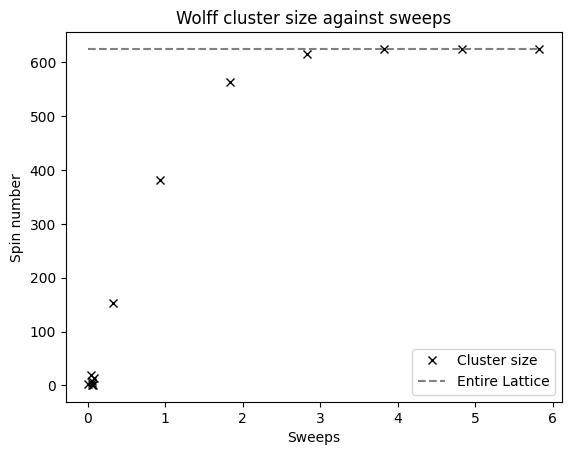

In [13]:
Wolff_cluster_size = []
for i in range(len(Wolff_sweeps)):
    # Reverse sweeps to get cluster size
    if i == 0:
        Wolff_cluster_size.append(Wolff_sweeps[i]*(25**2))
    else:
        Wolff_cluster_size.append((Wolff_sweeps[i] - Wolff_sweeps[i-1])*(25**2))

# Plot
plt.plot(Wolff_sweeps[1:15], Wolff_cluster_size[1:15], color = 'black', marker = 'x', linestyle = 'None', label = 'Cluster size')
plt.plot([np.min(Wolff_sweeps[1:15]),np.max(Wolff_sweeps[1:15])], [25**2,25**2], label = 'Entire Lattice', linestyle = '--', color = 'gray')
plt.xlabel('Sweeps')
plt.ylabel('Spin number')
plt.title('Wolff cluster size against sweeps')
plt.legend()
plt.show()

*Fig. 7 showing the rapid increase in cluster size for the Wolff algorithm*

This large cluster size, reaching the size of the whole lattice in $\sim 3 sweeps$, allows the Wolff algorithm to explore the state space much faster, hence reaching the equilibrium state faster. This consideration was then further applied to the internal energy $E$ of the system.

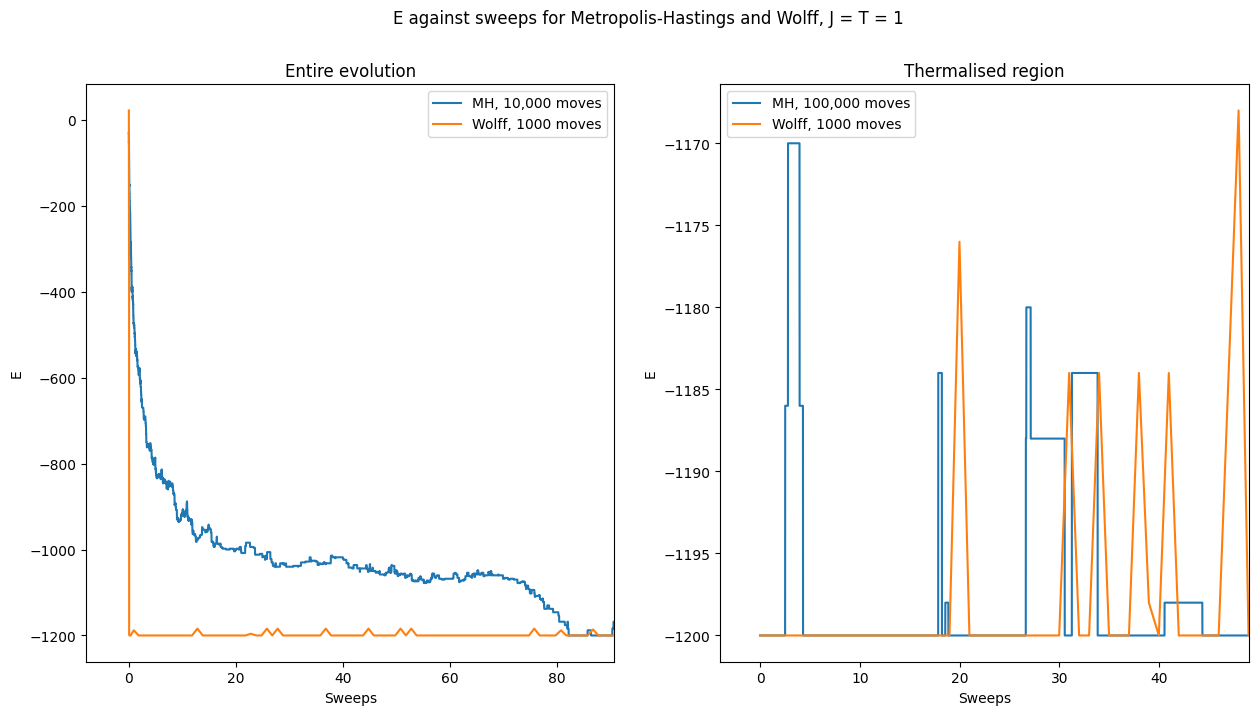

In [14]:
# Load Data:
MH_sweeps = np.load('MH_thermalisation_sweeps.npy')
MH_Es = np.load('MH_thermalisation_Es.npy')
MH_thermal_Es = np.load('MH_thermalised_Es.npy')
MH_thermal_sweeps = np.load('MH_thermalised_sweeps.npy')
Wolff_Es = np.load('Wolff_thermalisation_Es.npy')
Wolff_sweeps = np.load('Wolff_thermalisation_sweeps.npy')
Wolff_thermal_Es = np.load('Wolff_thermalised_Es.npy')
Wolff_thermal_sweeps = np.load('Wolff_thermalised_sweeps.npy')

# Plot data
fig, ax  = plt.subplots(1,2, figsize = (15,7.5))
ax[0].plot(MH_sweeps, MH_Es, label = 'MH, 10,000 moves')
ax[0].plot(Wolff_sweeps, Wolff_Es, label = 'Wolff, 1000 moves')
ax[0].set_xlim(right = min(MH_sweeps[-1],Wolff_sweeps[-1]))
ax[0].legend()
ax[1].plot(MH_thermal_sweeps, MH_thermal_Es, label = 'MH, 100,000 moves')
ax[1].plot(Wolff_thermal_sweeps, Wolff_thermal_Es, label = 'Wolff, 1000 moves')
ax[1].set_xlabel('Sweeps')
ax[0].set_xlabel('Sweeps')
ax[1].set_xlim(right = min(MH_thermal_sweeps[-1],Wolff_thermal_sweeps[-1]))
ax[1].set_ylabel(r'E')
ax[0].set_ylabel(r'E')
ax[0].set_title('Entire evolution')
ax[1].set_title('Thermalised region')
ax[1].legend()
fig.suptitle(r'E against sweeps for Metropolis-Hastings and Wolff, J = T = 1')
plt.show()

*Fig. 8 - Internal energy $E$ evolution for the two algorithms.*

It is again clear that Wolff equilibrates in many fewer sweeps. For both $\vert M \vert$ and $E$ that many fewer Wolff steps were required overall, suggesting Thatt the Wolff algorithm is more efficient in reaching equilibrium. Finally, note that, as expected, the number of sweeps to equilibrate (and hence the autocorrelation time) differs for the two observables, as expected from the discussion in section 2.6.

### 3.3 - Agreement to analytic solutions

To more quantitavely check the data produced by these algorithms, The batch averaged absolute spontaneous magnetisation per spin are calculated for temperatures in the range $ 1 \le T \le 5$ for the $2 \times 2$ case for both algorithms. For MH, a burn of $500,000$ moves was performed to ensure equlibrium was reached. The data was collected over $10,000$ moves. For Wolff, a burn of $500$ steps was performed for the same reason, and data was collected over $750$ more moves. The Magnetisations were measured using a batching method as discussed in section 2.7. 

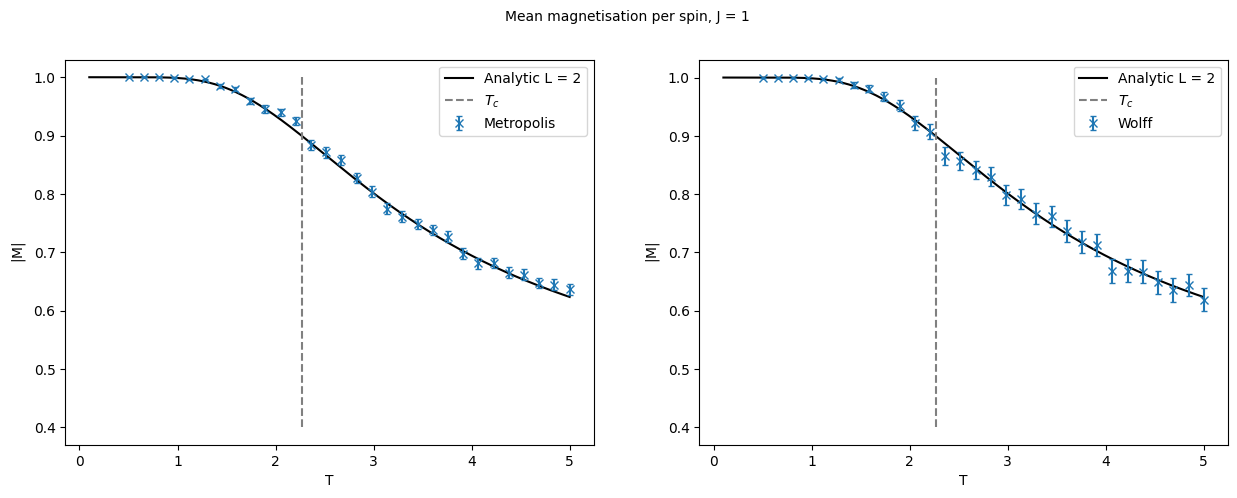

In [15]:
#First calculate analytic solution as outline in report:
J = 1
Ts_2x2 = np.linspace(0.1,5,1000)
Ms_2x2 = []
T_c = 2*J/np.log(1 + np.sqrt(2)) # Critical temperature
for T in Ts_2x2:
    Ms_2x2.append(0.25*(8*np.exp(8*T**-1)+16)/(4*np.cosh(8*T**-1)+12))

# Load data:
Ts_MH = np.linspace(0.5,5,30)
Ts_Wolff = np.linspace(0.5,5,30)
Ms_MH = np.load('Ms_MH_against_T_2x2.npy')
Ms_MH_err = np.load('Ms_MH_against_T_2x2_err.npy')
Ms_Wolff = np.load('Ms_Wolff_against_T_2x2.npy')
Ms_Wolff_err = np.load('Ms_Wolff_against_T_2x2_err.npy')

#Plot data
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(Ts_2x2, Ms_2x2, label = 'Analytic L = 2', color = 'black')
ax[1].plot(Ts_2x2, Ms_2x2, label = 'Analytic L = 2', color = 'black')
ax[0].plot(np.full((5,1),T_c), np.linspace(0.4,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
ax[1].plot(np.full((5,1),T_c), np.linspace(0.4,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
ax[0].errorbar(Ts_MH, np.abs(Ms_MH), yerr = Ms_MH_err, label = 'Metropolis', capsize= 2, linestyle = 'None', marker = 'x')
ax[1].errorbar(Ts_Wolff, np.abs(Ms_Wolff), yerr = Ms_Wolff_err, label = 'Wolff', capsize= 2, linestyle = 'None', marker = 'x')
ax[0].set_xlabel('T')
ax[1].set_xlabel('T')
ax[0].set_ylabel(r'$\vert$M$\vert$')
ax[1].set_ylabel(r'$\vert$M$\vert$')
fig.suptitle('Mean magnetisation per spin, J = ' + str(J), fontsize = 10)
ax[0].legend()
ax[1].legend()
plt.show()

*Fig. 9 - plot of spontanteous magnetism against temperature for a $2 \times 2$ lattice*

This process was then repeated for the internal energy of the system, with an MH burn of 100,000 steps and data collection of 100,000 steps. Wolff was burned for 500 steps and data collected over 2000 steps.

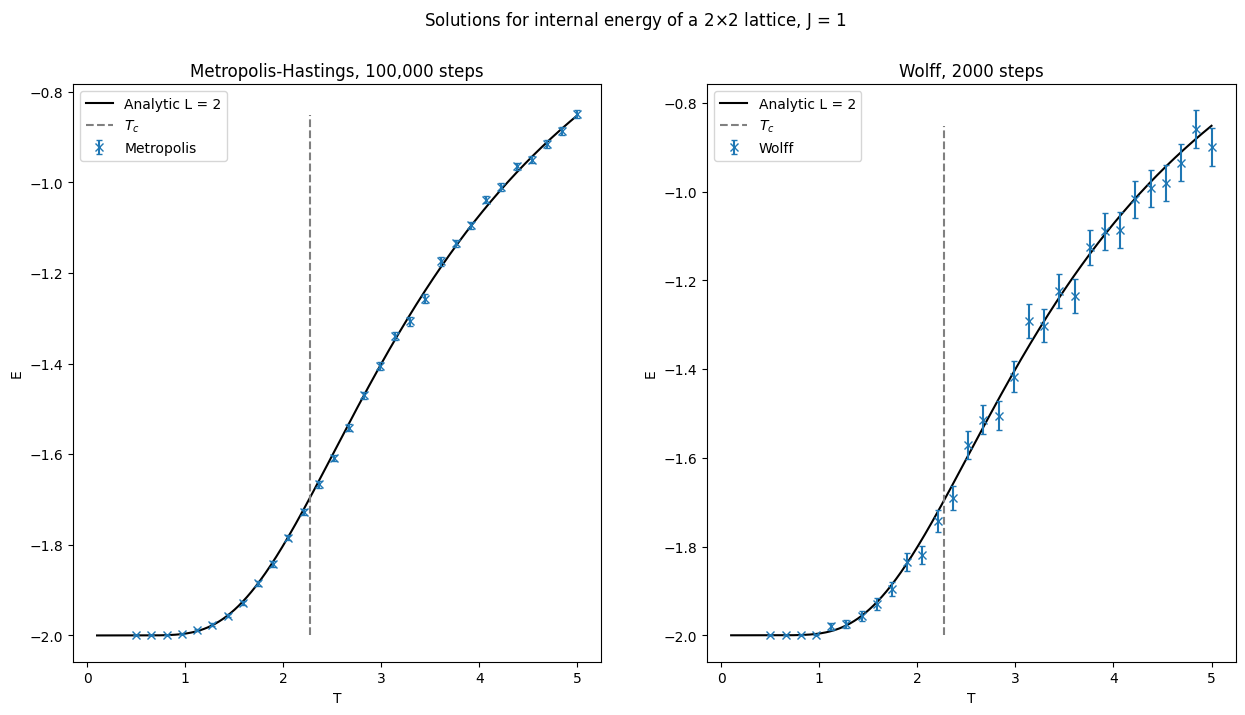

In [16]:
Es_MH = np.load('Es_MH_against_T_2x2.npy')
Es_MH_err = np.load('Es_MH_against_T_2x2_err.npy')
Es_Wolff = np.load('Es_Wolff_against_T_2x2.npy')
Es_Wolff_err = np.load('Es_Wolff_against_T_2x2_err.npy')

fig, ax = plt.subplots(1, 2, figsize = (15,7.5))
ax[0].plot(Ts_2x2, Es_2x2, label = 'Analytic L = 2', color = 'black')
ax[1].plot(Ts_2x2, Es_2x2, label = 'Analytic L = 2', color = 'black')
ax[0].plot(np.full((5,1),T_c), np.linspace(np.min(Es_2x2),np.max(Es_2x2),5), linestyle = '--', color = 'gray', label = r'$T_c$')
ax[1].plot(np.full((5,1),T_c), np.linspace(np.min(Es_2x2),np.max(Es_2x2),5), linestyle = '--', color = 'gray', label = r'$T_c$')
ax[0].errorbar(Ts_MH, Es_MH, yerr = Es_MH_err, label = 'Metropolis', capsize= 2, linestyle = 'None', marker = 'x')
ax[1].errorbar(Ts_Wolff, Es_Wolff, yerr = Es_Wolff_err, label = 'Wolff', capsize= 2, linestyle = 'None', marker = 'x')
for i in range(2):
    ax[i].set_xlabel('T')
    ax[i].set_ylabel('E')
    ax[i].legend()
ax[0].set_title('Metropolis-Hastings, 100,000 steps')
ax[1].set_title('Wolff, 2000 steps')
fig.suptitle(r'Solutions for internal energy of a 2$\times$2 lattice, J = ' + str(J))
plt.show()

*Fig. 10 - plot of internal energy against magnetism for a $2 \times 2\$ lattice.*

The agreement of both algorithms to the analytic exact solution is good, with most data points within error of the true solution. The agreement is especially good in the low temperature for both algorithms, and the error is very small. The error of data points for the Wolff algorithm are larger, particularly in the high temperature regime, and the data points deviate more significantly from the analytic solution. The error is larger due to the generally smaller number of bins present in the Wolff data. Although the autocorrelation times for Wolff were generally smaller, Wolff took significantly more CPU time per iteration and hence to obtain data in a reasonable period of time a smaller number of total moves was used. The Wolff deviations from equilibrium not seen in the MH algorithm are likely due to Wolff being a rejection free algorithm, meaning it necessarily explores the state space around equilibrium, whereas the MH algorithm may not.

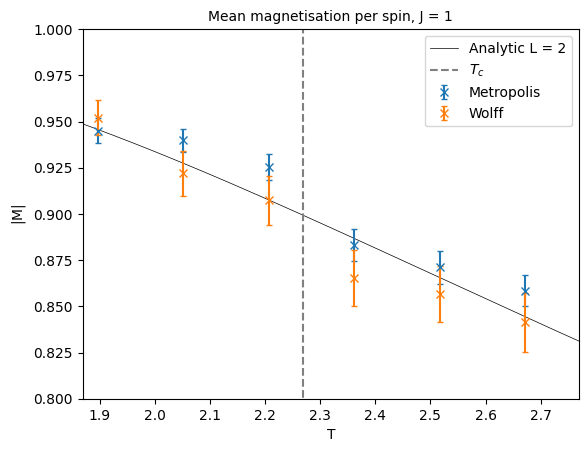

In [17]:
#First calculate analytic solution as outline in report:
J = 1
Ts_2x2 = np.linspace(0.1,5,1000)
Ms_2x2 = []
T_c = 2*J/np.log(1 + np.sqrt(2)) # Critical temperature
for T in Ts_2x2:
    Ms_2x2.append(0.25*(8*np.exp(8*T**-1)+16)/(4*np.cosh(8*T**-1)+12))

# Load data:
Ts_MH = np.linspace(0.5,5,30)
Ts_Wolff = np.linspace(0.5,5,30)
Ms_MH = np.load('Ms_MH_against_T_2x2.npy')
Ms_MH_err = np.load('Ms_MH_against_T_2x2_err.npy')
Ms_Wolff = np.load('Ms_Wolff_against_T_2x2.npy')
Ms_Wolff_err = np.load('Ms_Wolff_against_T_2x2_err.npy')

#Plot data
plt.plot(Ts_2x2, Ms_2x2, label = 'Analytic L = 2', color = 'black', linewidth = 0.5)
plt.plot(np.full((5,1),T_c), np.linspace(0.4,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.errorbar(Ts_MH, np.abs(Ms_MH), yerr = Ms_MH_err, label = 'Metropolis', capsize= 2, linestyle = 'None', marker = 'x')
plt.errorbar(Ts_Wolff, np.abs(Ms_Wolff), yerr = Ms_Wolff_err, label = 'Wolff', capsize= 2, linestyle = 'None', marker = 'x')
plt.xlabel('T')
plt.ylabel(r'$\vert$M$\vert$')
plt.title('Mean magnetisation per spin, J = ' + str(J), fontsize = 10)
plt.legend()
plt.xlim((T_c - 0.4, T_c + 0.5))
plt.ylim((0.8,1))
plt.show()

*Fig. 9 - plot of spontanteous magnetism against temperature for a $2 \times 2$ lattice near to $T_c$*

Both algorithms had smaller bin numbers in the blocking method near to the critical temperature. This is a manifestation of the critical slowing down phenomena that affects both algorithms. The autocorrelation length increases, leading to more data needed per bin. Figure 9 shows the MH and Wolff measurements near to the critical temperature. Both algorithms produce at least one data point not in agreement with the analytic solution in this region. This outlines some of the issues these methods face about the critical temperature, which will be explored in more detail.

The good agreement with the small lattice case increases confidence in the physical accuracy of these two methods. A final check of a $100 \times 100$ lattice spontaneous magnetisation per spin was simulated and compared to the Onsager solution.

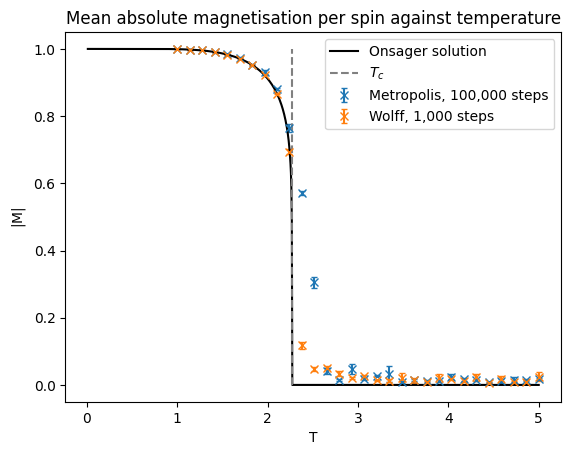

In [18]:
# Load data:
Ts_algorithm = np.linspace(1,5,30)
Ms_MH = np.load('MH_M_against_T.npy')
Ms_Wolff = np.load('Wolff_M_against_T.npy')
Ms_MH_err = np.load('MH_M_against_T_err.npy')
Ms_Wolff_err = np.load('Wolff_M_against_T_err.npy')

# Plot along with Onsager solution
plt.errorbar(Ts_algorithm, np.abs(Ms_MH), yerr = Ms_MH_err, label = 'Metropolis, 100,000 steps', capsize= 2, marker = 'x', linestyle = 'None')
plt.errorbar(Ts_algorithm, np.abs(Ms_Wolff), yerr = Ms_Wolff_err, label = 'Wolff, 1,000 steps', capsize= 2, marker = 'x', linestyle = 'None')
plt.plot(Ts_analytic, M_analytic, color = 'black', label  = 'Onsager solution')
plt.plot(np.full((5,1),T_c), np.linspace(0,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.xlabel('T')
plt.ylabel(r'$\vert$M$\vert$')
plt.title(r'Mean absolute magnetisation per spin against temperature')
plt.legend()
plt.show()

*Fig. 11 - plot of simulated spontanteous magnetism against temperature for a $100 \times 100$ lattice and the Onsager solution*

Both algorithms are consistent with each other and the Onsager solution at low temperatures. For high temperatures, the algorithms agree well. Both fluctuate in values a small amount above the Onsager solution, which is not physcially expected. This is a systematic error due to the absolute magnetism being taken, meaning all fluctations about the expected $ \vert M \vert = 0 $ are taken to be positive, raising the average for each data point. This systematic error, while clear here, is does not affect the analysis in this report elsewhere. Both algorithms display the expected 'smoothing out' of the Onsager solution, deviating from it around $T_c$. However in the critical region the two methods behave significantly differently, The metropolis curve appears to deviate more from the Onsager solution. This is possibly due to the significantly larger autocorrelations that the Metropolis algorithm displays in the critical region. This is explored further later in the report.

To conclude this section, the two computational methods tested in this report show satisfactory agreement to the analytical solutions available.

### 3.4 - Autocorrelation

As discussed in section 2.6, the autocorrelation time is an important quantitative tool to illustrate the extent of critical slowing down. Firstly, the sample autocorrelation for both algorithms on a $25 \times 25$ lattice was plotted against sweeps. The autocorrelation was determined using *statsmodels.api*, which has an inbuilt autocorrelation function. The autocorrelation was measured for both the magnetisation and internal energy separately. The auto correlation time was approximated as discussed in section 2.6, by taking the first value of autocorrelation such that $\bar{\rho} \le e^{-1}$. The figures below are the mean of five separate instances of the autocorrelation evolution for both Wolff and MH. MH was performed with a burn and measurement of $100,000$ moves each. For Wolff the burn in and measurement move lengths were $1,000$ moves each.

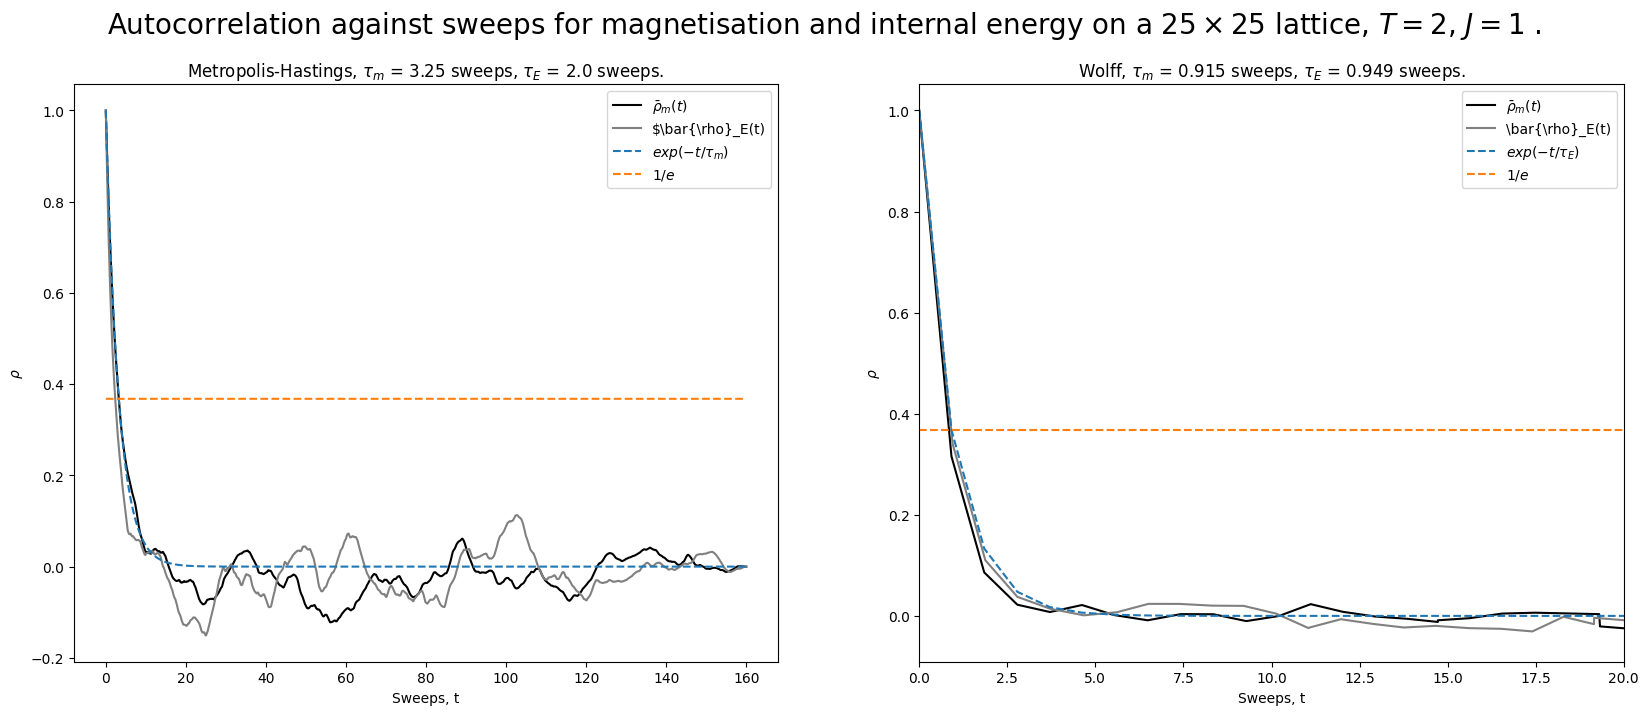

In [19]:
sweeps_MH = np.load('MH_autocorr_evolution_sweeps.npy')
autocorr_MH = np.load('MH_autocorr_evolution_autocorr.npy')
sweeps_tau_f_MH = np.load('MH_autocorr_evolution_sweeps_tau_f.npy')
E_sweeps_MH = np.load('MH_autocorr_evolution_sweeps_E.npy')
E_autocorr_MH = np.load('MH_autocorr_evolution_autocorr_E.npy')
E_sweeps_tau_f_MH = np.load('MH_autocorr_evolution_sweeps_tau_f_E.npy')
# plot computed autocorrelation
fig, ax = plt.subplots(1, 2, figsize = (20,7.5))
ax[0].plot(sweeps_MH, autocorr_MH, color = 'black', label = r'$\bar{\rho}_m(t)$')
ax[0].plot(E_sweeps_MH, E_autocorr_MH, color = 'gray', label = r'$\bar{\rho}_E(t)')
# plot expected exponential decay behaviour
ax[0].plot(sweeps_MH,[np.exp(-t/sweeps_tau_f_MH) for t in sweeps_MH], label = r'$exp(-t/ \tau_m)$', linestyle = '--')
# plot 1/e line
ax[0].plot(sweeps_MH, [np.exp(-1) for x in sweeps_MH], label = r'$1/e$', linestyle = '--')
ax[0].set_xlabel('Sweeps, t')
ax[0].set_ylabel(r'$\rho$')
ax[0].set_title(r'Metropolis-Hastings, $\tau_m$ = ' + str(np.round(sweeps_tau_f_MH,3)) + r' sweeps, $\tau_E$ = ' +str(np.round(E_sweeps_tau_f_MH)) + ' sweeps.' )
ax[0].legend()


# Load simulation data for Wolff
sweeps_Wolff = np.load('Wolff_autocorr_evolution_sweeps.npy')
autocorr_Wolff = np.load('Wolff_autocorr_evolution_autocorr.npy')
sweeps_tau_f_Wolff = np.load('Wolff_auto_corr_evolution_sweeps_tau_f.npy')
E_sweeps_Wolff = np.load('Wolff_autocorr_evolution_sweeps_E.npy')
E_autocorr_Wolff = np.load('Wolff_autocorr_evolution_autocorr_E.npy')
E_sweeps_tau_f_Wolff = np.load('Wolff_auto_corr_evolution_sweeps_tau_f_E.npy')
# plot computed autocorrelation
ax[1].plot(sweeps_Wolff, autocorr_Wolff, color = 'black', label = r'$\bar{\rho}_m(t)$')
ax[1].plot(E_sweeps_Wolff, E_autocorr_Wolff, color = 'gray', label = r'\bar{\rho}_E(t)')
# plot expected exponential decay behaviour
ax[1].plot(sweeps_Wolff,[np.exp(-t/sweeps_tau_f_Wolff) for t in sweeps_Wolff], label = r'$exp(-t/ \tau_E)$', linestyle = '--')
# plot 1/e line
ax[1].plot(sweeps_Wolff, [np.exp(-1) for x in sweeps_Wolff], label = r'$1/e$', linestyle = '--')
ax[1].set_xlabel('Sweeps, t')
ax[1].set_ylabel(r'$\rho$')
ax[1].set_title(r'Wolff, $\tau_m$ = ' + str(np.round(sweeps_tau_f_Wolff,3)) + r' sweeps, $\tau_E$ = ' + str(np.round(E_sweeps_tau_f_Wolff, 3)) + ' sweeps.')
ax[1].legend()
ax[1].set_xlim((0,20))
fig.suptitle(r'Autocorrelation against sweeps for magnetisation and internal energy on a $25 \times 25$ lattice, $T = 2$, $J = 1$ .', fontsize = 20)
plt.show()


*Fig. 12 - plots of magnetisaion autocorrelation against sweeeps for a $25 \times 25$  lattice at $T = 2$ and $J = 1$ for the Metropolis-Hastings and Wolff algorithms.*

C:\Users\jackb\AppData\Local\Temp\ipykernel_25124\557518237.py:7: RuntimeWarning: invalid value encountered in log
  ax[0].plot(sweeps_MH, np.log(autocorr_MH), color = 'black', label = r'$ln(\bar{\rho}_m(t))$')
C:\Users\jackb\AppData\Local\Temp\ipykernel_25124\557518237.py:8: RuntimeWarning: invalid value encountered in log
  ax[0].plot(E_sweeps_MH, np.log(E_autocorr_MH), color = 'gray', label = r'$ln(\bar{\rho}_E(t))$')
C:\Users\jackb\AppData\Local\Temp\ipykernel_25124\557518237.py:24: RuntimeWarning: invalid value encountered in log
  ax[1].plot(sweeps_Wolff, np.log(autocorr_Wolff), color = 'black', label = r'$ln(\bar{\rho}_m(t))$')
C:\Users\jackb\AppData\Local\Temp\ipykernel_25124\557518237.py:25: RuntimeWarning: invalid value encountered in log
  ax[1].plot(E_sweeps_Wolff, np.log(E_autocorr_Wolff), color = 'gray', label = r'ln(\bar{\rho}_E(t))$')


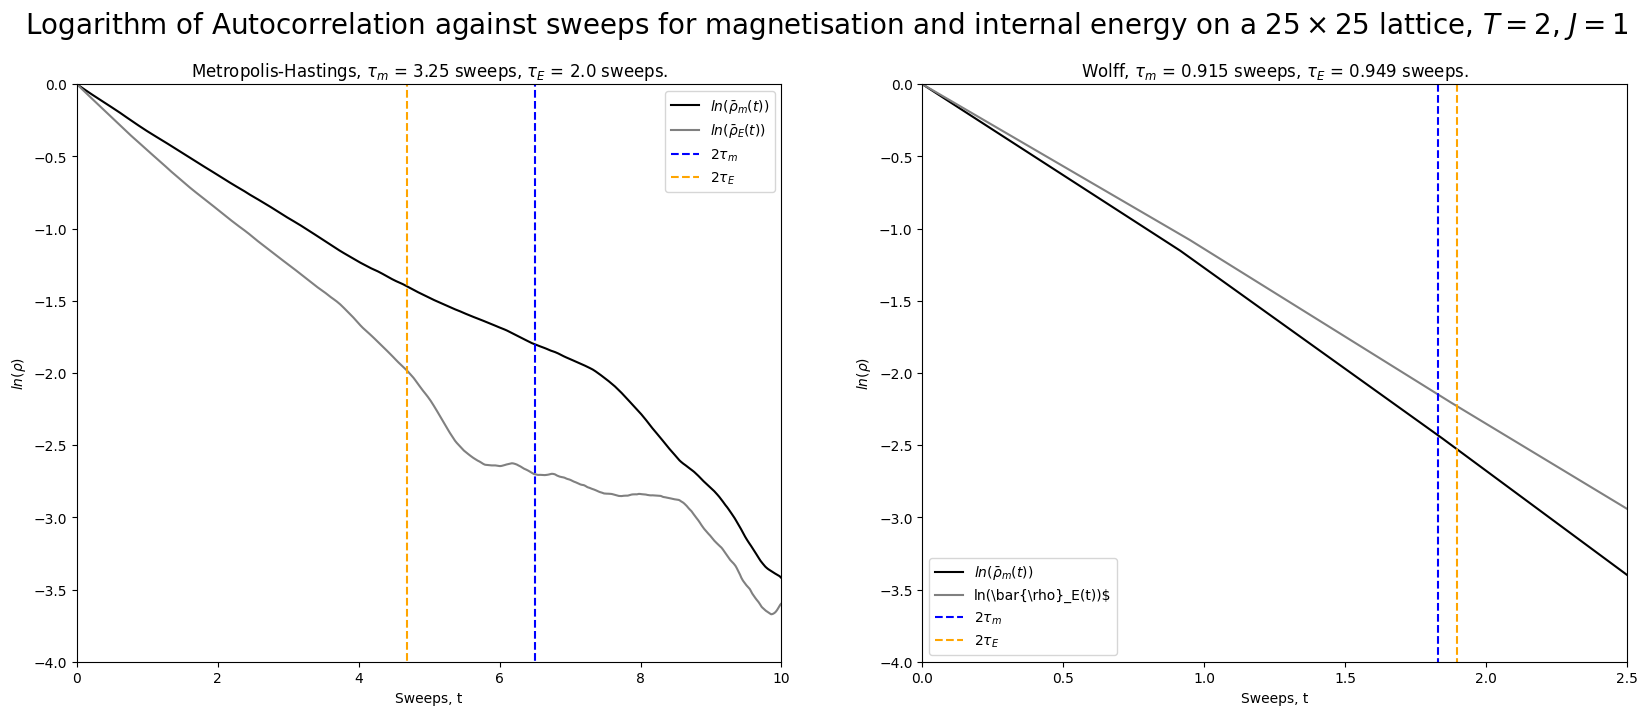

In [238]:
# Load data
sweeps_MH = np.load('MH_autocorr_evolution_sweeps.npy')
autocorr_MH = np.load('MH_autocorr_evolution_autocorr.npy')
sweeps_tau_f_MH = np.load('MH_autocorr_evolution_sweeps_tau_f.npy')
# plot computed autocorrelation
fig, ax = plt.subplots(1,2, figsize = (20,7.5))
ax[0].plot(sweeps_MH, np.log(autocorr_MH), color = 'black', label = r'$ln(\bar{\rho}_m(t))$')
ax[0].plot(E_sweeps_MH, np.log(E_autocorr_MH), color = 'gray', label = r'$ln(\bar{\rho}_E(t))$')
ax[0].set_xlabel('Sweeps, t')
ax[0].plot((2*sweeps_tau_f_MH, 2*sweeps_tau_f_MH), (-12,0), linestyle = '--', color = 'blue', label = r'$2\tau_m$')
ax[0].plot((2*E_sweeps_tau_f_MH, 2*E_sweeps_tau_f_MH), (-12,0), linestyle = '--', color = 'orange', label = r'$2\tau_E$')
ax[0].set_ylabel(r'$ln(\rho$)')
ax[0].set_title(r'Metropolis-Hastings, $\tau_m$ = ' + str(np.round(sweeps_tau_f_MH,3)) + r' sweeps, $\tau_E$ = ' +str(np.round(E_sweeps_tau_f_MH)) + ' sweeps.' )
ax[0].set_xlim((0,10))
ax[0].set_ylim((-4,0))
ax[0].legend()


# Load simulation data for Wolff
sweeps_Wolff = np.load('Wolff_autocorr_evolution_sweeps.npy')
autocorr_Wolff = np.load('Wolff_autocorr_evolution_autocorr.npy')
sweeps_tau_f_Wolff = np.load('Wolff_auto_corr_evolution_sweeps_tau_f.npy')
# plot computed autocorrelation
ax[1].plot(sweeps_Wolff, np.log(autocorr_Wolff), color = 'black', label = r'$ln(\bar{\rho}_m(t))$')
ax[1].plot(E_sweeps_Wolff, np.log(E_autocorr_Wolff), color = 'gray', label = r'ln(\bar{\rho}_E(t))$')
ax[1].plot((2*sweeps_tau_f_Wolff, 2*sweeps_tau_f_Wolff), (0, -4), linestyle = '--', color = 'blue', label = r'$2\tau_m$')
ax[1].plot((2*E_sweeps_tau_f_Wolff, 2*E_sweeps_tau_f_Wolff), (0, -4), linestyle = '--', color = 'orange', label = r'$2\tau_E$')
ax[1].set_xlabel('Sweeps, t')
ax[1].set_ylabel(r'$ln(\rho)$')
ax[1].set_title(r'Wolff, $\tau_m$ = ' + str(np.round(sweeps_tau_f_Wolff,3)) + r' sweeps, $\tau_E$ = ' + str(np.round(E_sweeps_tau_f_Wolff, 3)) + ' sweeps.')
ax[1].legend()
ax[1].set_xlim((0,2.5))
ax[1].set_ylim((-4,0))
fig.suptitle(r'Logarithm of Autocorrelation against sweeps for magnetisation and internal energy on a $25 \times 25$ lattice, $T = 2$, $J = 1$', fontsize = 20)
plt.show()

*Fig. 13 - logarithmic plots of magnetisation  and internal energy autocorelation against sweeps with $2 \tau_m$ marked.*

Wolff displays a significantly shorter autocorrelation time for both observables than the Metropolis-Hastings algorithm. This helps to justify the use of fewer overall iterations in a run for Wolff, as the blocking bin size will be smaller. From figure 13, it is clear that, up to $ \sim 2 \tau_f $, the sample autocorrelation for an observable $f$ closely follows the assumed exponential decay behaviour. It is also clear that, as expected, the autocorrelation time differs for different variables.

The critical slowing down of the algorithms was investigated by plotting the dependence of the magnetisation autocorrelation time against temperature on a $30 \times 30$ lattice. For MH, the burn and data collection were both performed over $50,000$ moves, and for Wolff both were performed over $1,000$ sweeps.

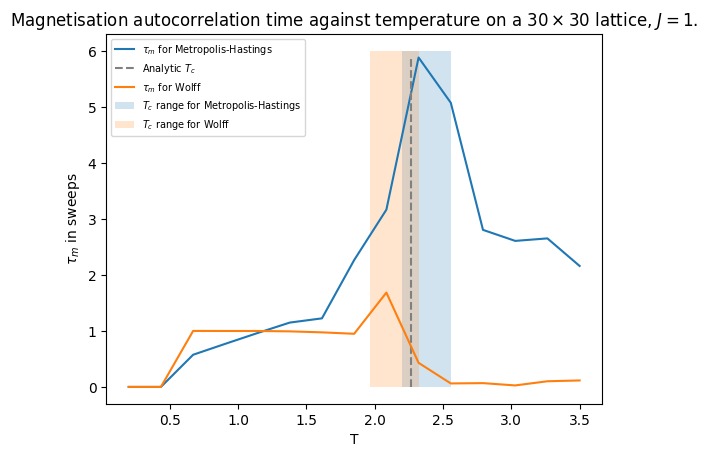

In [77]:
# Load data
autocorr_times_MH = np.load('MH_autocorrelation_against_T.npy')
autocorr_times_Wolff = np.load('Wolff_autocorrelation_against_T.npy')
T_c_MH = np.load('T_c_MH.npy')
T_c_Wolff = np.load('T_c_Wolff.npy')
Ts = np.linspace(0.2,3.5,15)

# plot the data:
plt.plot(Ts,autocorr_times_MH, label = r'$\tau_m$ for Metropolis-Hastings')
plt.plot(np.full((10,1),T_c),np.linspace(0,np.max(autocorr_times_MH),10), color = 'gray', linestyle = '--', label = r'Analytic $T_c$')
plt.title(r'Magnetisation autocorrelation time against temperature on a $ 30 \times 30 $ lattice, $J = 1$.')
plt.plot(Ts,autocorr_times_Wolff, label = r'$\tau_m$ for Wolff')
plt.ylabel(r'$\tau_m$ in sweeps')
plt.xlabel('T')
plt.fill_betweenx(np.linspace(0,6,10), T_c_MH - 0.5*(Ts[1]-Ts[0]), T_c_MH + (Ts[1]-Ts[0]), alpha = .2, label = r'$T_c$ range for Metropolis-Hastings')
plt.fill_betweenx(np.linspace(0,6,10), T_c_Wolff - 0.5*(Ts[1]-Ts[0]), T_c_Wolff + (Ts[1]-Ts[0]), alpha = .2, label = r'$T_c$ range for Wolff')
plt.legend(loc = 'upper left', fontsize = 7)
plt.show()

*Fig. 14 - Magnetisation autocorrelation time against temperature for the Wolff and Metropolis-Hastings algorithms against temperature. with the measured pseudo critical temperatures for the two algorithms. Analytic $T_C$ is plotted for reference.*

It is evident that the autocorrelation time for both algorithms is larger around $T_c$ than far from it. The Wolff algorithm maintains a smaller autocorrelation time around this point, showing that the cluster updates allow for more efficient measurement of observables about the Ising model's phase transition. In fact, this cluster method produces a lower autocorrelation or comparable autocorrelation time for all measured temperatures.

This behaviour shows the issue of critical slowing down as a limitation of these algorithms. At $T \sim T_c$, the autocorrelation time grows in magnitude. Therefore, the required number of iterations needed between collection of uncorrelated samples becomes much larger, and the CPU time to collect data grows. For MH, $\tau_m$ is up to a factor  of $\sim 6$ larger at $T_c$ than below $T_c$. This therefore require $6$ times more iterations to obtain the same number of uncorrelated samples. For a large scale lattice or a large number of uncorrelated samples, the CPU time is likely to already be large far from $T_c$. This larger autocorrelation time near $T_c$ would make collection of samples in the critical region infeasibly slow. The Wolff algorithm displays a much smaller autocorrelation time near $T_c$ than Wolff. Additionally, the autocorrelation time is only a factor of $\sim 2$ larger in the critical region than below $T_c$. Therefore, althought the Wolff algorithm is still affected by the issue of critical slowing down, it is to a much smaller extent than the MH algorithm.

The value of the critical temperature for each method is estimated using the temperature of the maximum autocorrelation time, with discretisation error from the coarse temperature scale considered in the error. These measured values are: $T_c = 2.32 \pm 0.22$ for MH and $T_c = 2.09\pm 0.22$ for Wolff. The Onsager value is $T_c = 2.26(9...)$[2]. This is consistent with both the MH and Wolff meaaurements.

The above process was repeated in full for the internal energy of the $30 \times 30$ lattice. The burn and data collection for MH was reduced to $10,000$ and $25,000$ moves respectively, and for Wolff they were reducedd to $750$ moves each due to the increases CPU time required to calculate internal energy.

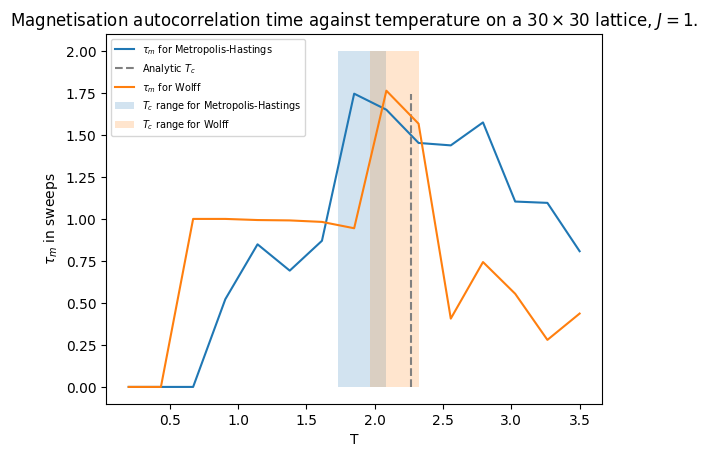

In [76]:
'''Plot tau V T for energy'''
# Load data
autocorr_times_MH = np.load('MH_E_autocorrelation_against_T.npy')
autocorr_times_Wolff = np.load('Wolff_E_autocorrelation_against_T.npy')
T_c_MH_E = np.load('T_c_MH_E.npy')
T_c_Wolff_E = np.load('T_c_Wolff_E.npy')
Ts = np.linspace(0.2,3.5,15)

# plot the data:
plt.plot(Ts,autocorr_times_MH, label = r'$\tau_m$ for Metropolis-Hastings')
plt.plot(np.full((10,1),T_c),np.linspace(0,np.max(autocorr_times_MH),10), color = 'gray', linestyle = '--', label = r'Analytic $T_c$')
plt.title(r'Magnetisation autocorrelation time against temperature on a $ 30 \times 30 $ lattice, $J = 1$.')
plt.plot(Ts,autocorr_times_Wolff, label = r'$\tau_m$ for Wolff')
plt.ylabel(r'$\tau_m$ in sweeps')
plt.xlabel('T')
plt.fill_betweenx(np.linspace(0,2,10), T_c_MH_E - 0.5*(Ts[1]-Ts[0]), T_c_MH_E + (Ts[1]-Ts[0]), alpha = .2, label = r'$T_c$ range for Metropolis-Hastings')
plt.fill_betweenx(np.linspace(0,2,10), T_c_Wolff_E - 0.5*(Ts[1]-Ts[0]), T_c_Wolff_E + (Ts[1]-Ts[0]), alpha = .2, label = r'$T_c$ range for Wolff')
plt.legend(loc = 'upper left', fontsize = 7)
plt.show()

*Fig 15 - Internal energy autocorrelation time against temperature for the Wolff and Metropolis-Hastings algorithms against temperature. with the measured pseudo critical temperatures for the two algorithms. Analytic $T_C$ is plotted for reference.* 

The value of critical temperatures for this energy plot was calculated in the same was as for the magnetisation plot. The measured values were $1.85 \pm 0.22 $ and $2.09 \pm 0.22$ for Metropolis hastings and Wolff respectively. The Wolff value is consistent with the analytic $T_c$, whereas the MH value is not.

Figure 15 suggests that energy measurements appear to be less affected by the critical slowing of the algorithms for MH. The Wolff algorithm displays similar behaviour in both cases.

This error could be explained by the significant difference in behaviour of the two algorithms near the critical temperature seen in figure 11. This error may be caused by the fact that, at $T_c$, the lattice fluctuates on all scales as discussed in section 2.6. Therefore, the periodic boundary conditions become a more significant effect on the system behaviour than outside the critical region. This also suggests that single spin updates may be less accurate than the clusters generated by the Wolff algorithm. This may affect the position of the measured critical temperature. However further investigation is needed to determine why this may affect the MH energy measurement and not the MH magnetisation.

An overall estimate of $T_c$ for each method was calculated by averaging the two separate measurements and using the standard error propagation formula below.

$(\sigma_Z)^2 = \frac{1}{2} (\sigma_A)^2 + (\sigma_B)^2 $ (25) [8]

Where $Z = \frac{1}{2}(A + B)$ and the two measurements of $T_c$ are treated as wholly independent as they arise from separate observable simulations. This average is performed as physically, it is expected that the phase transition encompasses both energy and magnetism at the same time. The final measurements are $2.09 \pm 0.22$ for both MH and Wolff. This is promising, as both algorithms give mutually consisten critical temperatures that are within error of the analytic value. The fractional error of $11%$ could be reduced by measuring the crtical temperature with each algorithm in more ways.

It is worth noting that the critical temperature of a finite lattice is expected to scale with lattice length with the formula below:

$T_c(L) = T_c(L \rightarrow \infty) +  \alpha L^{-1/\nu}$ (26) [9]

However, as discussed in section 2.6, $\alpha = 0$ for the two dimensional case so this should not affect critical temperatures measurted in this report. Further investigation beyond the scope of this report is required to determine whether the measured critical temperature are fully consistent with the Onsager solution. 

### 3.5 - Finite scaling laws

To conclude the investigation into the issue of critical slowing down, equation 21 was tested for the two methods. The expected relationship of $\tau_f \sim L^{z}$ in the critical region is known as the finite scaling law, and is an innate property of the algorithm used to simulate Ising model behaviour. This is an important measure of the feasability of an algorithm, as it determines the extent to which the iteration time must be increased as lattice size is increased. For most real world applications, the lattice must be very large, as the lattice spacing will be of order $1 \AA$. Although lattices of these size cannot be handled in reasonable times on the personal computer utilised for this report, the finite size scaling law should give an estimate of the algorithms ability to handle large lattices.

The autocorrelation was determined from an average 25 equilibrium measurements of the magnetisation autocorrelation for each algorithm. All tests were performed at the measured mean $T_c$ from section 3.4. The MH burn was $10,000$ moves and data was collected over $50,000$ moves. For Wolff, the burn and measurement were $1,000$ and $2,000$ moves respectively.  

*Fig. 16 - doubly logarithmic plot of $\tau_f$ against $L$ for both the Metropolis-Hastings and Wolff algorithms*

commments, literature values [10]

### 3.6 - Complexity

A discussion of the utility of a computational technique must include consideration of the computation time and its dependence on the variables at hand. It is already apparent that the MH algorithm will take many more iterations to reach the desired final state and generate independent samples around the phase transition than the Wolff. However, the process of cluster creation in this iteration of the Wolff algorithm requires repeated iteration over the seeding list. Although the Wolff algorithm flips more spins on average per move than the MH algorithm, this cluster seeding process suggests that a single move will almost always take longer

The computational time to execute one iteration of each algorithm was calculated for varying number of spins $N$ and separately for varying temperature $T$. The results are plotted below in figure 11. For varying $N$, $T = 1$ and $J = 1$ were held constant. Conversely, for varying $J$, $T = 1$ and $N = 10000$ were held constant. Each data point for $T$ was the mean of 20 measurements, with error calculated using the naive formula, as a single loop does not require sample correlation considerations. Similarly, each data point for $N$ was the mean of 5 measurements again with error calculated using the naive formula.

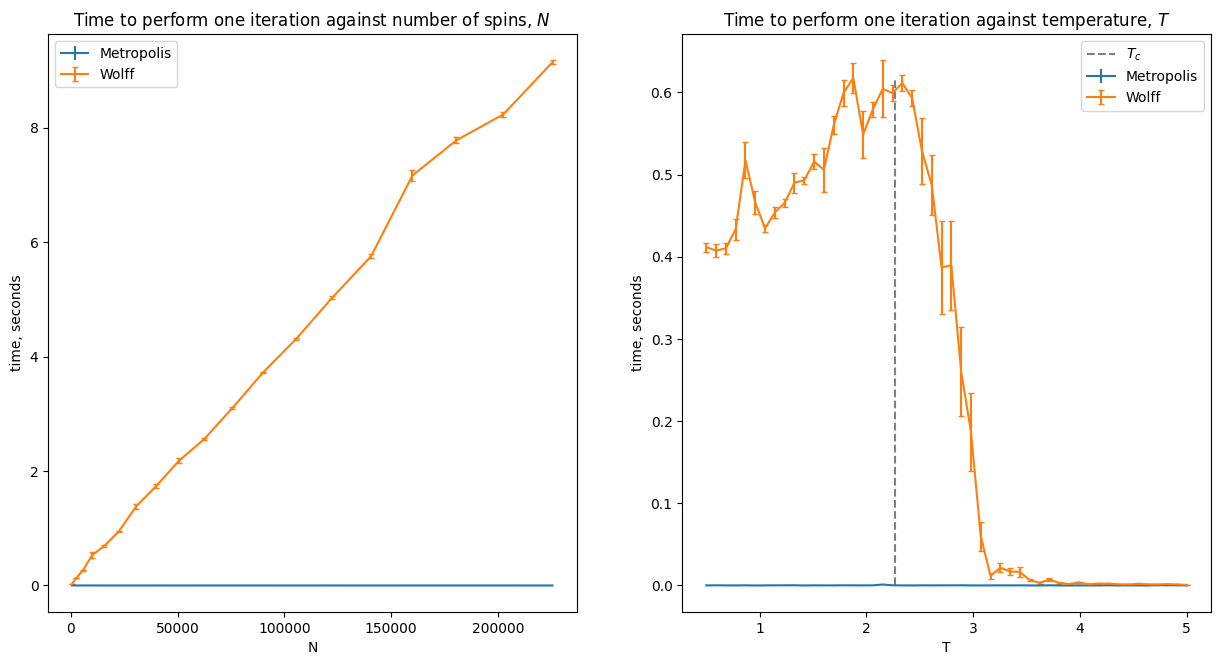

In [80]:
# Load and initialise data
Ts = np.linspace(0.5,5,50)
lattice_widths = np.arange(25,500,25)
fig, ax = plt.subplots(1,2, figsize = (15,7.5))
MH_execute_time_width = np.load('MH_execute_time_against_width.npy')
Wolff_execute_time_width = np.load('Wolff_execute_time_against_width.npy')
MH_execute_time_T = np.load('MH_execute_time_against_T.npy')
Wolff_execute_time_T = np.load('Wolff_execute_time_against_T.npy')
MH_execute_time_T_err = np.load('MH_execution_time_against_T_err.npy')
Wolff_execute_time_T_err = np.load('Wolff_execute_time_against_T_err.npy')
MH_execute_time_width_err = np.load('MH_execution_time_against_width_err.npy')
Wolff_execute_time_width_err = np.load('Wolff_execute_time_against_width_err.npy')

# Plot data
ax[1].errorbar(Ts, MH_execute_time_T, yerr = MH_execute_time_T_err, label = 'Metropolis')
ax[1].errorbar(Ts,Wolff_execute_time_T, yerr = Wolff_execute_time_T_err,label = 'Wolff', capsize = 2)
ax[1].plot(np.full((5,1),T_c),np.linspace(0,np.max(Wolff_execute_time_T),5), linestyle = '--', color = 'gray', label = r'$T_c$')
ax[1].legend()
ax[1].set_xlabel('T')
ax[1].set_ylabel('time, seconds')
ax[1].set_title(r'Time to perform one iteration against temperature, $T$')
ax[0].errorbar(lattice_widths**2, MH_execute_time_width, yerr = MH_execute_time_width_err, label = 'Metropolis')
ax[0].errorbar(lattice_widths**2, Wolff_execute_time_width, yerr = Wolff_execute_time_width_err,label = 'Wolff', capsize = 2)
ax[0].legend()
ax[0].set_xlabel('N')
ax[0].set_ylabel('time, seconds')
ax[0].set_title(r'Time to perform one iteration against number of spins, $N$')
plt.show()

*Fig. 17 - plots of execution time for a single iteration of the Wolff and Metropolis-Hastings algorithms against varying $N$ and $J$. Specifications of the hardware this was performed with are in the appendix.*

An iteration of the Wolff algorithm takes longer than an MH algorithm generally, as expected. The MH step has no noticeable dependance on either of $T$ or $N$. Wolff iterations display a linear dependence on $N$, and a complex dependence on $T$, with a increase into the critical region that then decays rapidly to an approximately constant time per iteration.

The MH step does not seed clusters or make any sort of list manipulation; T plays into the probability of flipping a list element, which is $\mathcal{O}(1)$[11]. The size of the lattice does not enter into the algorithm at all. Hence, the MH algorithm's lack of dependence on $N$ and $T$ seems reasonable.

For larger temperatures, the probability a spin is added to the cluster decays rapidly to zero. Hence, the significantly faster iteration times for larger temperatures suggests that the cluster seeding and pop function list manipulation is indeed the rate limiting process for the Wolff algorithm. This is consistent with the width measurements, as the larger the lattice, the larger the clusters that can be formed. As shown in figure 7, the cluster size at $T=1$ quickly tends to the whole lattice, and hence it makes sense that the iteration has overall complexity $\mathcal{O}(N)$.

To further investigate this relationship for the Wolff algorithm, $1000$ iterations of the algorithm were performed on a $25 \times 25$ lattice for varying $T$ and average cluster size against coupling strength plotted in the figure below.

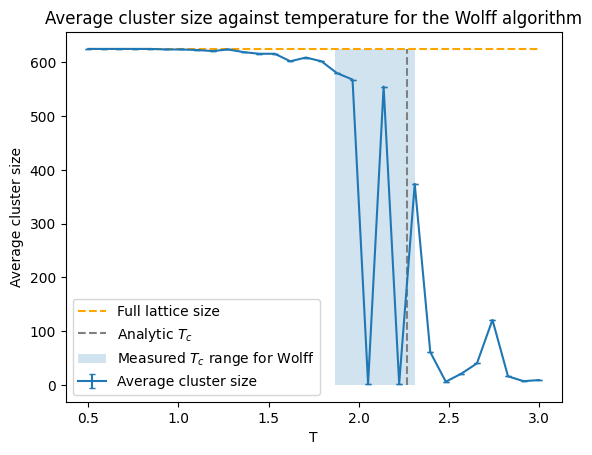

In [87]:
# Load data 
cluster_size_against_T = np.load('cluster_size_against_T.npy')
cluster_size_against_T_err = np.load('cluster_size_against_T_err.npy')
Ts = np.linspace(0.5,3, 30)

plt.plot(Ts, np.full((30,1), 25**2), label = 'Full lattice size', linestyle = '--', color = 'orange')
plt.errorbar(Ts, cluster_size_against_T, yerr = cluster_size_against_T_err, label = 'Average cluster size', capsize = 2)
plt.plot(np.full((5,1), T_c), np.linspace(0,np.max(cluster_size_against_T),5), linestyle = '--', color = 'gray', label = r'Analytic $T_c$')
plt.fill_betweenx(np.linspace(0,625,10), 2.09 - 0.22, 2.09 + 0.22, alpha = .2, label = r'Measured $T_c$ range for Wolff')
plt.xlabel('T')
plt.ylabel('Average cluster size')
plt.title('Average cluster size against temperature for the Wolff algorithm')
plt.legend()
plt.show()

*Fig. 18 - a graph showing average cluster size against coupling strength for the Wolff algorithm on a $25 \times 25$ lattice.*

The cluster size below $T_c$ is approximately the size of the lattice, and above $T_c$ is significantly smaller. This suggests that it is indeed the large clusters at low temperatures that are causing the significant slowing. For the majority of this report, the Wolff algorithm's CPU time was the major factor that contributed to CPU time for simulations, and was preventative to the investigation of very large lattices on the personal computer on which simulations were performed. The main focus of optimisation attempts was therefore put into the Woflf algorithm, however no significant improvements in CPU time were made.

## 4 - Conclusion

The Metropolis-Hastings and Wolff algorithms were investigated in comparison to known analytic solutions of the 2 dimensional square lattice Ising model and compared on the basis of critical slowing down and applicability to large lattices. Both algorithms showed good agreement to the analytic $2 \times 2$ lattice and Onsager solutions, with some small but significant discrepancies around the crticial temperature of the Onsager solution. The autocorrelation time of the algorithms was measured against temperature and lattice width to determine the finite size scaling law of the two algorithms. The autocorrelation times for both implemented algorithms peaked around the critical temperature, signalling the presence of critical slowing down around the Ising model's phase transtion. The critical temperatures measured from this data was $2.09 \pm 0.22$ for both algorithms. This is within error of the Onsager critical temperature. The dynamic exponent measurements for the algorithms were ____  and ____ respectively. These are(nt) in agreement with previously published dynamic exponents. The regression to determine these was(nt) of satisfactory $R^2$. The CPU complexity of the two algorithms was also tested. The Wolff algorithm displayed $\mathcal{O}(N)$ complexity on the number of spins, and a complex dependence on temperature mediated by the average cluster size. The Metropolis-Hastings algorithm showed no noteable dependence on either.

To conclude, the Wolff algorithm showed a significantly lesser degree of critical slowing down than the Metropolis-Hastings algorithm. Although attempts to determine the finite size scaling law of these algorithms was unsuccessful, it is the writer's opinion that the Wolff algorithm is the more feasible option for large lattices based upon other autocorrelation dependances explored in this reprot and previous literature. However, the Metropolis-Hastings algorithm has on distinct advantage. The Metropolis-Hastings algorithm is a general Markov Chain Monte Carlo method, widely applicable to other contexts, whereas the Wolff algorithm is solely applicable to the Ising model.



## References

1. *Thermal and Statistical Physics Supplementary Course Handout*, Terentjev, 2022, University of Cambridge, https://www-teach.phy.cam.ac.uk/dms/dms_getFile.php?node=43344
2. *Part II computational physics, Monte Carlo methods*, Lamacraft et al., 2023, University of Cambridge, https://computational-physics.tripos.org/notes/monte-carlo.html
3. *Monte-Carlo simulations in the 2-dimensional Ising Model*, Bourached, 2015, Trinity College Dublin
4. *Monte Carlo Techniques, 5. MCMC in practice*, Budd, 2022, Radboud University, https://hef.ru.nl/~tbudd/mct/lectures/mcmc_in_practice.html
5. *Spin Glass Models 4: Ising Model-Simulation*, Cole, 2020, https://lewiscoleblog.com/spin-glass-models-4
6. *Parallelization of the Wolff Single-Cluster Algorithm*, Kaupužs et al., 2010, University of Latvia
7. *Ising Model and Phase Transitions*, Alessanro Codello, 2015, SISSA Trieste, https://universalitylectures.files.wordpress.com/2013/05/lecture_5_ising_model_and_phase_transitions_v1.pdf
8. Mathematical Formulae handbook, Dr Green, 2019, University of Cambridge https://www.phy.cam.ac.uk/system/files/documents/Formulaeversion2.5forwebsite201920.pdf
9. *The Hobbyhorse of Magnetic Systems: The Ising Model*, Padilla et al., 2016, European Journal of Physics
10. *Comparison of Monte Carlo Metropolis, Swendsen-Wang, and Wolff Algorithms in the Critical Region for the 2-dimensional Ising Model*, Kyimba et al., 2022, NC State University
11. *TimeComplexity*, AndrewBadr, 2023, https://wiki.python.org/moin/TimeComplexity

## Appendices
#### 1. Computer specifications
All tests were run in python 3.10.1 on a PC with Windows 11 home version 10.0.22621 N/A Build 22621. The CPU is an Intel Core i5-8265U with 4 cores and a base speed of 1.80GHz. 8GB of RAM is available, as well as an NVIDIA GeForce GTX 1650 Max-Q with 4GB dedicated VRAM and 4GB shared.